# Reinforcement Learning

Exercise to implement SARSA and Q-Learning on a Grid-World problem.


### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [7]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from sklearn.model_selection import ParameterGrid
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures as cf
from tqdm import tqdm

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

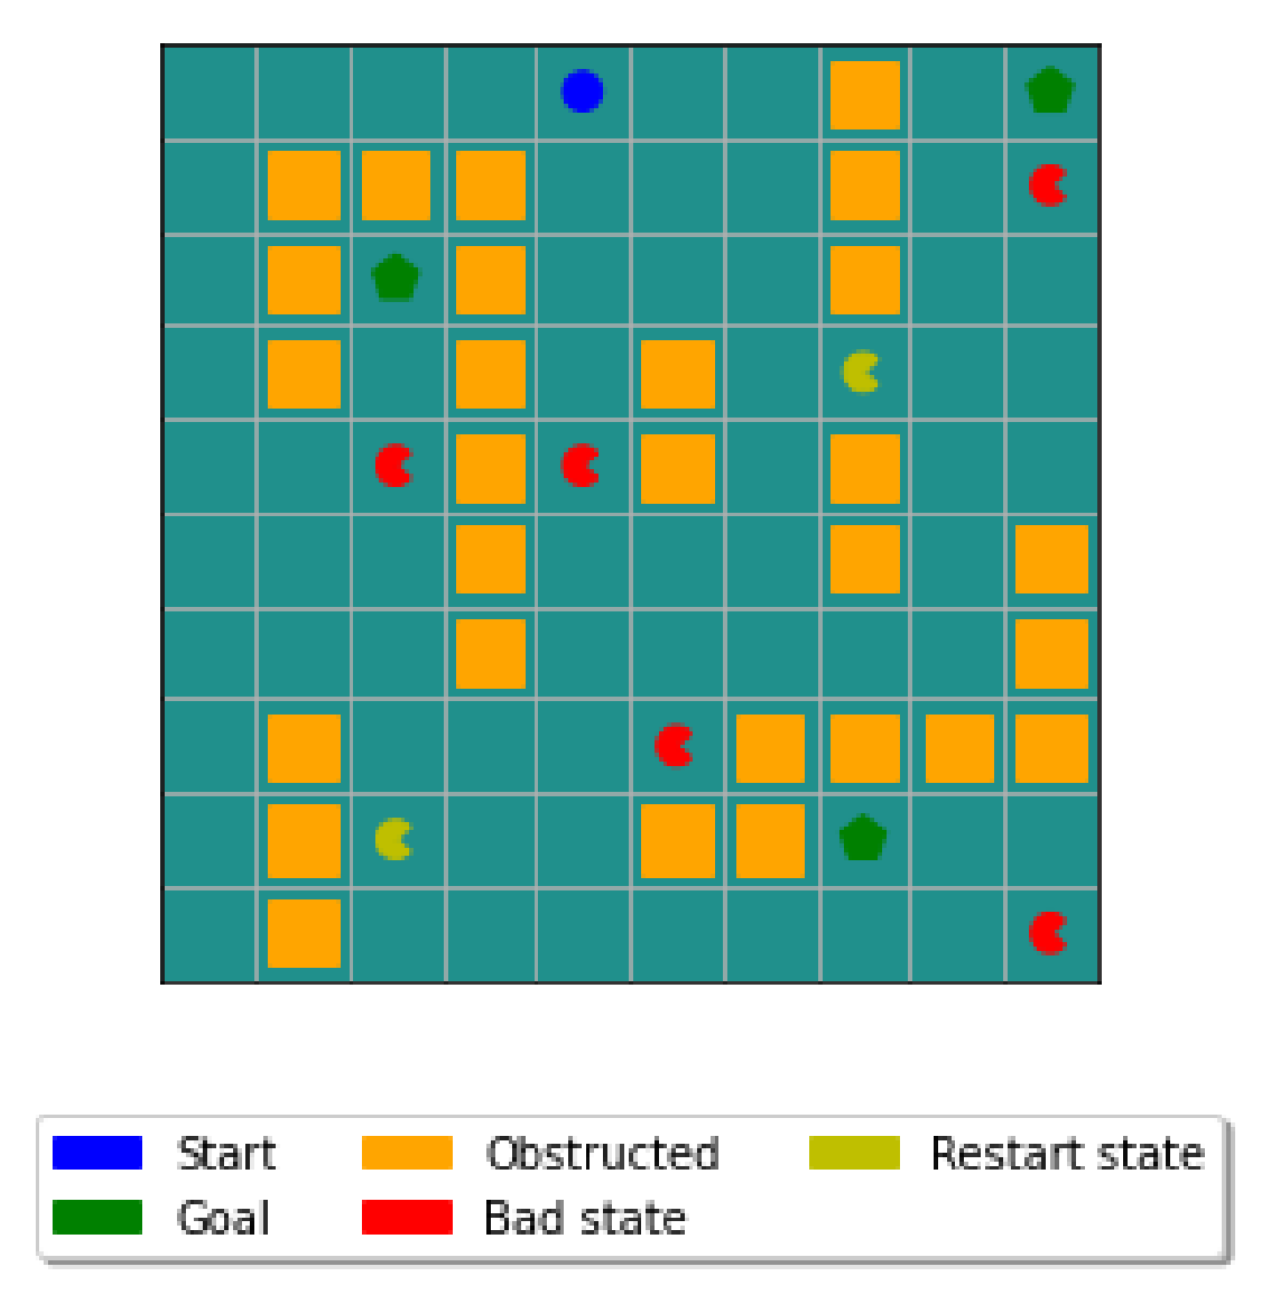

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

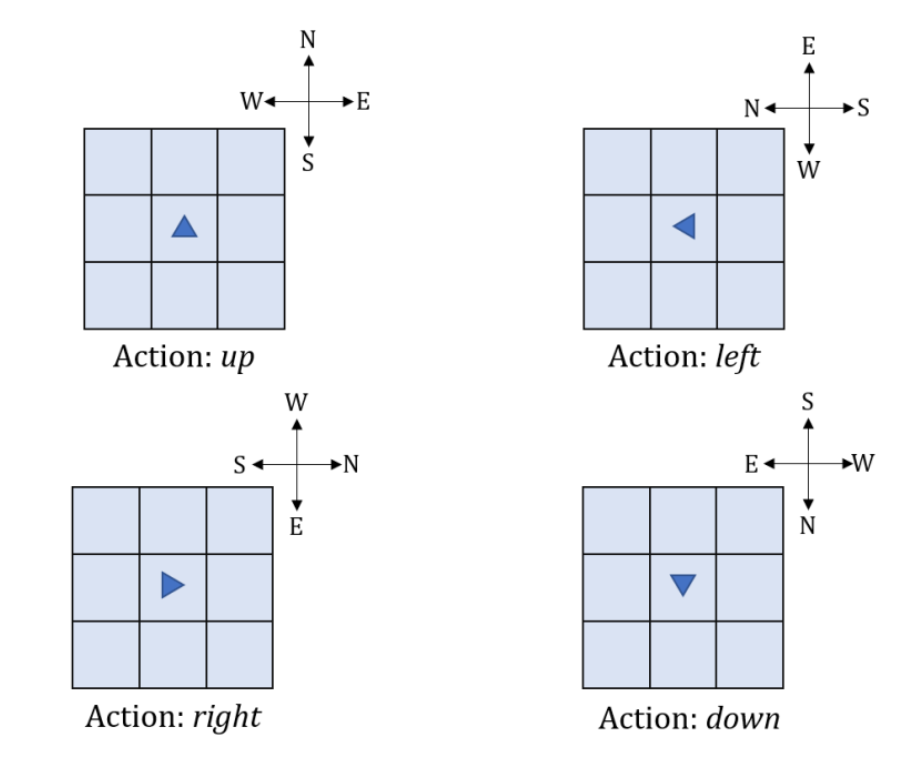

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [8]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [9]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [4]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [10]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- For each algorithm, There are total ***16 different configurations*** in total.
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

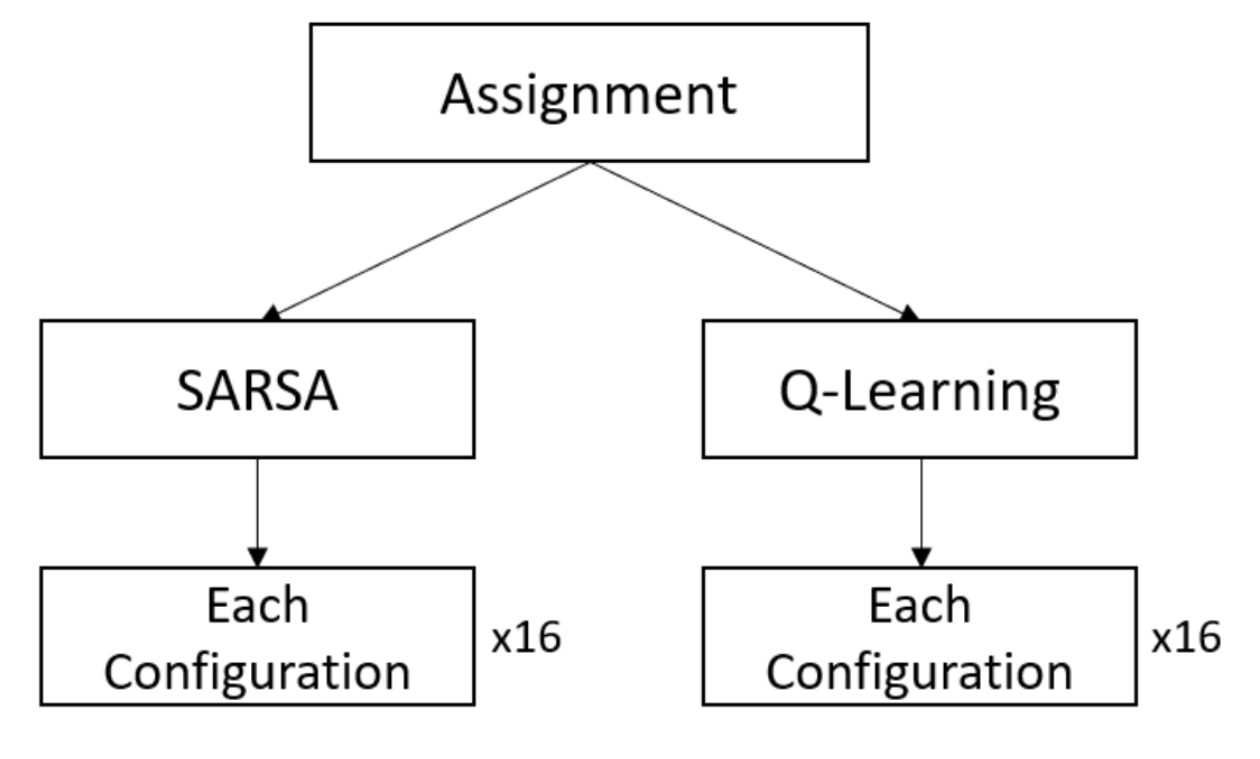

## Configurations

There are total 16 configurations 8 each for SARSA and Q-Learning).

#### Configuration Parameters
Learning algorithm =  [0.001, 0.01, 0.1, 1.0]

Wind for SARSA= [True, False]

Wind for Q-learning = [False]

Start State = [(0,4),(3,6)]

Value of $p$ for SARSA = 1

Value of $p$ for Q-learning = [1,0.7]

Exploration strategy = ['epsilon-greedy', 'softmax']

Train the agent

In [11]:
class RLAgent:
    def __init__(self, env, start, wind, alpha, gamma, epsilon, tau, p, algorithm, exploration_strategy):
        self.env = env
        self.start = start
        self.wind = wind
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.p = p
        self.algorithm = algorithm
        self.exploration_strategy = exploration_strategy
        self.q_values = defaultdict(lambda: np.zeros(env.num_actions).astype(int))
        self.steps_to_goal = []
        self.episode_rewards = []
        self.visit_counts = np.zeros((env.num_rows, env.num_cols)).astype(int)

    def epsilon_greedy_policy(self, state):
        if self.p < self.epsilon:
            return random.choice(range(self.env.num_actions))
        else:
            return np.argmax(self.q_values[state])

    def softmax_policy(self, state):
        q = self.q_values[state]
        max_q = np.max(q)
        exp_q = np.exp((q - max_q) / self.tau)
        probabilities = exp_q / np.sum(exp_q)
        if np.isnan(probabilities).any() or np.isinf(probabilities).any():
            probabilities = np.ones_like(probabilities) / len(probabilities)
        cum_probs = np.cumsum(probabilities)
        rand = np.random.rand()
        return np.searchsorted(cum_probs, rand)

    def learn(self, episodes, max_steps):
        for _ in range(episodes):
            state = self.env.reset()
            total_reward = 0
            step_count = 0
            action = self.epsilon_greedy_policy(state) if self.exploration_strategy == 'epsilon-greedy' else self.softmax_policy(state)

            for _ in range(max_steps):
                row, col = divmod(state, self.env.num_cols)
                self.visit_counts[row, col] += 1
                next_state, reward = self.env.step(state, action)
                total_reward += reward.item()
                step_count += 1

                if self.algorithm == 'SARSA':
                    next_action = self.epsilon_greedy_policy(next_state) if self.exploration_strategy == 'epsilon-greedy' else self.softmax_policy(next_state)
                    self.q_values[state][action] += self.alpha * (reward + self.gamma * self.q_values[next_state][next_action] - self.q_values[state][action])
                    state, action = next_state, next_action
                else:  # Q-Learning
                    next_action = np.argmax(self.q_values[next_state])
                    self.q_values[state][action] += self.alpha * (reward + self.gamma * self.q_values[next_state][next_action] - self.q_values[state][action])
                    state, action = next_state, self.epsilon_greedy_policy(next_state) if self.exploration_strategy == 'epsilon-greedy' else self.softmax_policy(next_state)

                if state in self.env.goal_states_seq:
                    break

            self.episode_rewards.append(total_reward)
            self.steps_to_goal.append(step_count)

    def get_visit_counts(self):
        return self.visit_counts
    
    def get_algorithm(self):
        return self.algorithm
    
    def get_hyperparameters(self):
        params = {
            'start_state': self.start,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'tau': self.tau,
            'p': self.p,
            'wind': self.wind,
            'exploration_strategy': self.exploration_strategy,
            'algorithm': self.algorithm
        }
        return params

    def get_optimal_policy_and_q_values(self):
        q_values = np.zeros((self.env.num_rows, self.env.num_cols))
        optimal_actions = np.zeros((self.env.num_rows, self.env.num_cols))
        print("Q-values inside", q_values)
        for state, actions in self.q_values.items():
            row, col = divmod(state, self.env.num_cols)
            q_values[row, col] = np.max(actions)
            optimal_actions[row, col] = np.argmax(actions)

        return q_values, optimal_actions

def train_agent(env, start, wind, alpha, gamma, epsilon, tau, p, episodes, max_steps, algorithm, exploration_strategy):
    agent = RLAgent(env, start, wind, alpha, gamma, epsilon, tau, p, algorithm, exploration_strategy)
    agent.learn(episodes, max_steps)
    return agent

In [7]:
# Configurations
sarsa_param_grid = {
    'start_state': [[0, 4], [3, 6]],
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'gamma': [0.7, 0.8, 0.9, 1.0],
    'epsilon': [0.001, 0.01, 0.05, 0.1],
    'tau': [0.01, 0.1, 1, 2],
    'p': [1],  # Specific p value for SARSA
    'wind': [True, False],  # Specific wind values for SARSA
    'exploration_strategy': ['epsilon-greedy', 'softmax'],
    'algorithm': ['SARSA']
}

qlearning_param_grid = {
    'start_state': [[0, 4], [3, 6]],
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'gamma': [0.7, 0.8, 0.9, 1.0],
    'epsilon': [0.001, 0.01, 0.05, 0.1],
    'tau': [0.01, 0.1, 1, 2],
    'p': [1.0, 0.7],  # Specific p value for Q-Learning
    'wind': [False],  # Specific wind values for Q-Learning
    'exploration_strategy': ['epsilon-greedy', 'softmax'],
    'algorithm': ['Q-Learning']
}

param_grids = [sarsa_param_grid, qlearning_param_grid]
configurations = [config for grid in param_grids for config in ParameterGrid(grid)]

max_steps = 100
n_agents = 50
episodes = 1000

# Best Hyperparameters and best rewards
best_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_rewards = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_agent = {'SARSA': {}, 'Q-Learning': {}}

# Best average Hyperparameters and best average rewards
best_avg_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_avg_reward = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_avg_agent = {'SARSA': {}, 'Q-Learning': {}}

# Aggregated visit counts
aggregated_visit_counts = {'SARSA': np.zeros((env.num_rows, env.num_cols)).astype(int), 'Q-Learning': np.zeros((env.num_rows, env.num_cols)).astype(int)}
n = {'SARSA': 0, 'Q-Learning': 0}

def calculate_best_parameters(agent: RLAgent):
    algorithm  = agent.get_algorithm()
    aggregated_visit_counts[algorithm] += agent.get_visit_counts()
    hyperparameters = agent.get_hyperparameters()
    n[algorithm] += 1
    best_reward = max(agent.episode_rewards)
    avg_reward = np.mean(agent.episode_rewards)

    if avg_reward > best_avg_reward[algorithm]:
        best_avg_reward[algorithm] = avg_reward
        best_avg_hyperparameters[algorithm] = hyperparameters
        best_avg_agent[algorithm] = agent

    if best_reward > best_rewards[algorithm]:
        best_rewards[algorithm] = best_reward
        best_hyperparameters[algorithm] = hyperparameters
        best_agent[algorithm] = agent

def run_training(config):
    start_state = config['start_state']
    alpha = config['alpha']
    gamma = config['gamma']
    epsilon = config['epsilon']
    tau = config['tau']
    p = config['p']
    wind = config['wind']
    exploration_strategy = config['exploration_strategy']
    algorithm = config['algorithm']

    #Thread safety
    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])
    start_state = np.array([start_state])
    goal_states = np.array([[0,9],[2,2],[8,7]])
    gw = GridWorld(num_rows=num_rows,num_cols=num_cols,start_state=start_state,goal_states=goal_states,wind = wind)
    gw.add_obstructions(obstructed_states=obstructions,bad_states=bad_states,restart_states=restart_states)
    gw.add_rewards(step_reward=-1,goal_reward=10,bad_state_reward=-6,restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,bias=0.5)
    env = gw.create_gridworld()

    agent = train_agent(env, start_state, wind, alpha, gamma, epsilon, tau, p, episodes=episodes, max_steps=max_steps, algorithm=algorithm, exploration_strategy=exploration_strategy)
    calculate_best_parameters(agent)
    return agent

expanded_configurations = [config for config in configurations for _ in range(n_agents)]

with ThreadPoolExecutor(max_workers=n_agents) as executor:
    results = list(tqdm(executor.map(run_training, configurations), total=len(configurations)))

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_60912/2130979137.py:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_60912/1254432311.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

  4%|▍         | 166/4096 [15:13<7:55:26,  7.26s/it]IOStream.flush timed out
IOStream.flush timed out
 23%|██▎       | 953/4096 [1:25:59<4:12:09,  4.81s/it] /var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_60912/1254432311.py:55: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element 

### Best and Average Rewards results from training of agents

In [50]:
agent_sarsa = best_agent['SARSA']
sarsa_hyperparameters = best_hyperparameters['SARSA']
sarsa_best_rewards = best_rewards['SARSA']

agent_qlearning = best_agent['Q-Learning']
qlearning_hyperparameters = best_hyperparameters['Q-Learning']
qlearning_best_rewards = best_rewards['Q-Learning']

agent_avg_sarsa = best_avg_agent['SARSA']
sarsa_avg_hyperparameters = best_avg_hyperparameters['SARSA']
sarsa_avg_rewards = best_avg_reward['SARSA']

agent_avg_qlearning = best_avg_agent['Q-Learning']
qlearning_avg_hyperparameters = best_avg_hyperparameters['Q-Learning']
qlearning_avg_rewards = best_avg_reward['Q-Learning']

sarsa_visit_count = aggregated_visit_counts['SARSA']
qlearning_visit_count = aggregated_visit_counts['Q-Learning']

sarsa_visit_average = np.divide(aggregated_visit_counts['SARSA'], n['SARSA']).astype(int)
qlearning_visit_average = np.divide(aggregated_visit_counts['Q-Learning'], n['Q-Learning']).astype(int)

q_values_sarsa, optimal_actions_sarsa = agent_sarsa.get_optimal_policy_and_q_values()
q_values_qlearning, optimal_actions_qlearning = agent_qlearning.get_optimal_policy_and_q_values()

print("Best Hyperparameters SARSA:", sarsa_hyperparameters)
print("Best Rewards SARSA:", sarsa_best_rewards)
print("Best Agent SARSA:", agent_sarsa)
print("Best Average Hyperparameters SARSA:", sarsa_avg_hyperparameters)
print("Best Average Rewards SARSA:", sarsa_avg_rewards)
print("Best Average Agent SARSA:", agent_avg_sarsa)
print("Sarsa Visit Count", sarsa_visit_count)
print("Sarsa Visit Count average", sarsa_visit_average)

print("Best Hyperparameters Q-Learning:", qlearning_hyperparameters)
print("Best Rewards Q-Learning:", qlearning_best_rewards)
print("Best Agent Q-Learning:", agent_qlearning)
print("Best Average Hyperparameters Q-Learning:", qlearning_avg_hyperparameters)
print("Best Average Rewards Q-Learning:", qlearning_avg_rewards)
print("Best Average Agent Q-Learning:", agent_avg_qlearning)
print("Q-Learning Visit Count", qlearning_visit_count)
print("Q-Learning Visit Count average", qlearning_visit_average)

print("n_sarsa:", n['SARSA'])
print("n_Q-Learning:", n['Q-Learning'])

print("Q-value SARSA:", q_values_sarsa)
print("Q-value Q-learning:", q_values_qlearning)

print("Optimal Actions SARSA:", optimal_actions_sarsa)
print("Optimal Actions Q-Learning:", optimal_actions_qlearning)

Best Hyperparameters SARSA: {'start_state': array([[3, 6]]), 'alpha': 1.0, 'gamma': 1.0, 'epsilon': 0.001, 'tau': 2, 'p': 1, 'wind': True, 'exploration_strategy': 'epsilon-greedy', 'algorithm': 'SARSA'}
Best Rewards SARSA: 1.0
Best Agent SARSA: <__main__.RLAgent object at 0x163d96bd0>
Best Average Hyperparameters SARSA: {'start_state': array([[0, 4]]), 'alpha': 1.0, 'gamma': 1.0, 'epsilon': 0.001, 'tau': 2, 'p': 1, 'wind': False, 'exploration_strategy': 'epsilon-greedy', 'algorithm': 'SARSA'}
Best Average Rewards SARSA: -31.713
Best Average Agent SARSA: <__main__.RLAgent object at 0x163d97fd0>
Sarsa Visit Count [[ 4974926  5795194  7145388  9462304 14322006 21357678 54762617        0
     53716        0]
 [  901635        0        0        0  3086273  4977120 11544224        0
    137824   294145]
 [  695714        0        0        0  2462605  3698469  7338029        0
    226279   711448]
 [  537032        0   109710        0  1731213        0  6487154  1168283
    375983  1298999]
 

In [12]:
def plot_rewards(agent_sarsa, agent_qlearning, title):
    plt.figure(figsize=(12, 6))
    plt.plot(agent_sarsa.episode_rewards, label='SARSA')
    plt.plot(agent_qlearning.episode_rewards, label='Q-learning')
    plt.title(f"{title} Rewards per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_steps(agent_sarsa, agent_qlearning, title):
    plt.figure(figsize=(12, 6))
    plt.plot(agent_sarsa.steps_to_goal, label='SARSA')
    plt.plot(agent_qlearning.steps_to_goal, label='Q-learning')
    plt.title(f"{title} Steps to Goal per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Steps to Goal')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_heatmap(visit_counts_sarsa, visit_counts_qlearning, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    cax1 = axes[0].matshow(visit_counts_sarsa, cmap='BuPu', interpolation='nearest')
    cax2 = axes[1].matshow(visit_counts_qlearning, cmap='BuPu', interpolation='nearest')

    fig.colorbar(cax1, ax=axes[0], label='Visit Counts')
    fig.colorbar(cax2, ax=axes[1], label='Visit Counts')
    
    axes[0].set_title(f'SARSA - {title}')
    axes[0].set_xlabel('Columns')
    axes[0].set_ylabel('Rows')

    axes[1].set_title(f'Q-learning - {title}')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Rows')

    for ax, visit_counts in zip(axes, [visit_counts_sarsa, visit_counts_qlearning]):
        for i in range(visit_counts.shape[0]):
            for j in range(visit_counts.shape[1]):
                ax.text(j, i, f'{int(visit_counts[i, j])}', va='center', ha='center', color='black', fontsize=8)

    plt.show()

def plot_q_values_and_optimal_actions(agent_sarsa, agent_qlearning, title):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    heatmap = ax.matshow(q_values_sarsa, cmap='coolwarm', interpolation='nearest')
    fig.colorbar(heatmap, ax=ax)
    ax.set_title(f'SARSA - {title}')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')

    for row in range(agent_sarsa.env.num_rows):
        for col in range(agent_sarsa.env.num_cols):
            if q_values_sarsa[row, col] != 0:
                action = optimal_actions_sarsa[row, col]
                if action == 0:  # Up
                    ax.arrow(col, row, 0, -0.5, head_width=0.3, head_length=0.3, fc='white', ec='white')
                elif action == 1:  # Down
                    ax.arrow(col, row, 0, 0.5, head_width=0.3, head_length=0.3, fc='white', ec='white')
                elif action == 2:  # Left
                    ax.arrow(col, row, -0.5, 0, head_width=0.3, head_length=0.3, fc='white', ec='white')
                elif action == 3:  # Right
                    ax.arrow(col, row, 0.5, 0, head_width=0.3, head_length=0.3, fc='white', ec='white')

    ax = axes[1]
    heatmap = ax.matshow(q_values_qlearning, cmap='coolwarm', interpolation='nearest')
    fig.colorbar(heatmap, ax=ax)
    ax.set_title(f'Q-learning - {title}')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')

    for row in range(agent_qlearning.env.num_rows):
        for col in range(agent_qlearning.env.num_cols):
            if q_values_qlearning[row, col] != 0:
                action = optimal_actions_qlearning[row, col]
                if action == 0:  # Up
                    ax.arrow(col, row, 0, -0.5, head_width=0.3, head_length=0.3, fc='white', ec='white')
                elif action == 1:  # Down
                    ax.arrow(col, row, 0, 0.5, head_width=0.3, head_length=0.3, fc='white', ec='white')
                elif action == 2:  # Left
                    ax.arrow(col, row, -0.5, 0, head_width=0.3, head_length=0.3, fc='white', ec='white')
                elif action == 3:  # Right
                    ax.arrow(col, row, 0.5, 0, head_width=0.3, head_length=0.3, fc='white', ec='white')

    plt.tight_layout()
    plt.show()

def plot_visit_counts(agent_sarsa, agent_qlearning, title):
    visit_counts_sarsa = agent_sarsa.get_visit_counts()
    visit_counts_qlearning = agent_qlearning.get_visit_counts()

    fig = make_subplots(rows=1, cols=2, subplot_titles=('SARSA', 'Q-Learning'))
    fig.add_trace(go.Heatmap(z=visit_counts_sarsa, colorscale='Viridis', showscale=False), row=1, col=1)

    fig.add_trace(go.Heatmap(z=visit_counts_qlearning, colorscale='Viridis', colorbar=dict(x=1.2)), row=1, col=2)
    fig.update_layout(
        title=title,
        height=370,
        width=800,
        margin=dict(t=50, b=50, l=50, r=200),
    )

    fig.show()

1. Plot reward curves (during the training phase with the best hyperparameters).

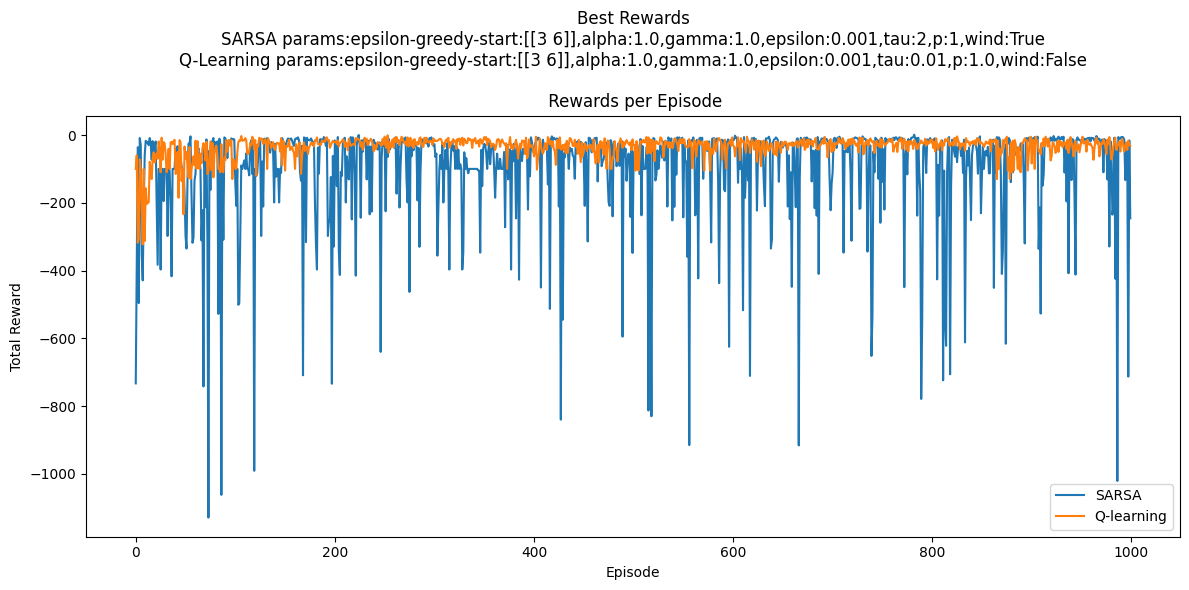

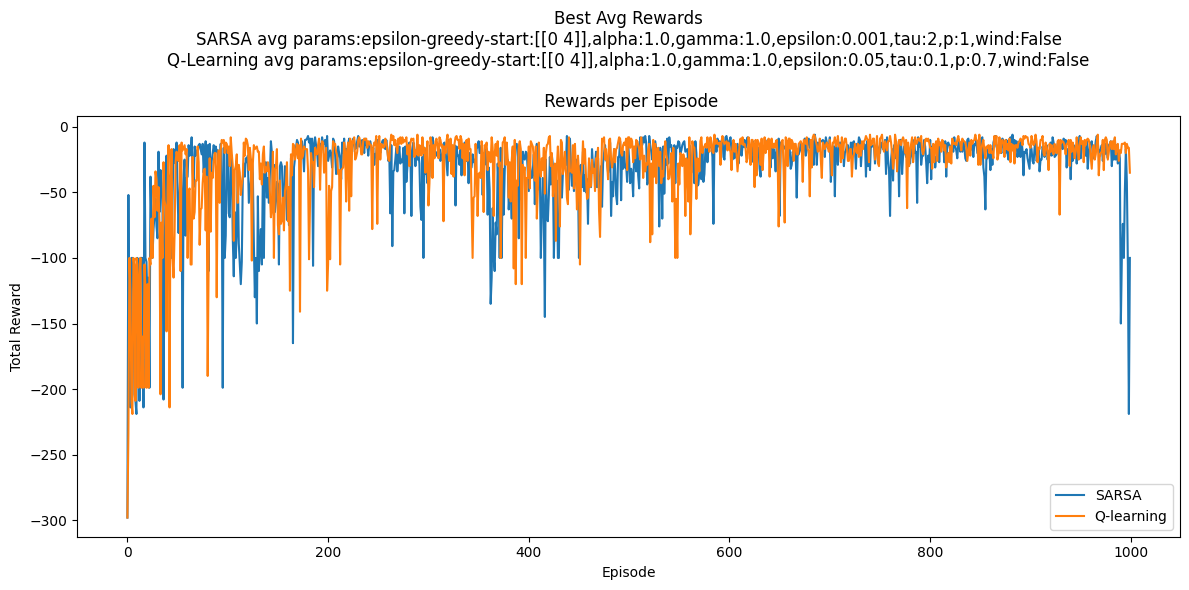

In [11]:
plot_rewards(agent_sarsa, agent_qlearning, f"Best Rewards\nSARSA params:{sarsa_hyperparameters['exploration_strategy']}-start:{sarsa_hyperparameters['start_state']},alpha:{sarsa_hyperparameters['alpha']},gamma:{sarsa_hyperparameters['gamma']},epsilon:{sarsa_hyperparameters['epsilon']},tau:{sarsa_hyperparameters['tau']},p:{sarsa_hyperparameters['p']},wind:{sarsa_hyperparameters['wind']}\nQ-Learning params:{qlearning_hyperparameters['exploration_strategy']}-start:{qlearning_hyperparameters['start_state']},alpha:{qlearning_hyperparameters['alpha']},gamma:{qlearning_hyperparameters['gamma']},epsilon:{qlearning_hyperparameters['epsilon']},tau:{qlearning_hyperparameters['tau']},p:{qlearning_hyperparameters['p']},wind:{qlearning_hyperparameters['wind']}\n\n")

plot_rewards(agent_avg_sarsa, agent_avg_qlearning, f"Best Avg Rewards\nSARSA avg params:{sarsa_avg_hyperparameters['exploration_strategy']}-start:{sarsa_avg_hyperparameters['start_state']},alpha:{sarsa_avg_hyperparameters['alpha']},gamma:{sarsa_avg_hyperparameters['gamma']},epsilon:{sarsa_avg_hyperparameters['epsilon']},tau:{sarsa_avg_hyperparameters['tau']},p:{sarsa_avg_hyperparameters['p']},wind:{sarsa_avg_hyperparameters['wind']}\nQ-Learning avg params:{qlearning_avg_hyperparameters['exploration_strategy']}-start:{qlearning_avg_hyperparameters['start_state']},alpha:{qlearning_avg_hyperparameters['alpha']},gamma:{qlearning_avg_hyperparameters['gamma']},epsilon:{qlearning_avg_hyperparameters['epsilon']},tau:{qlearning_avg_hyperparameters['tau']},p:{qlearning_avg_hyperparameters['p']},wind:{qlearning_avg_hyperparameters['wind']}\n\n")


2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

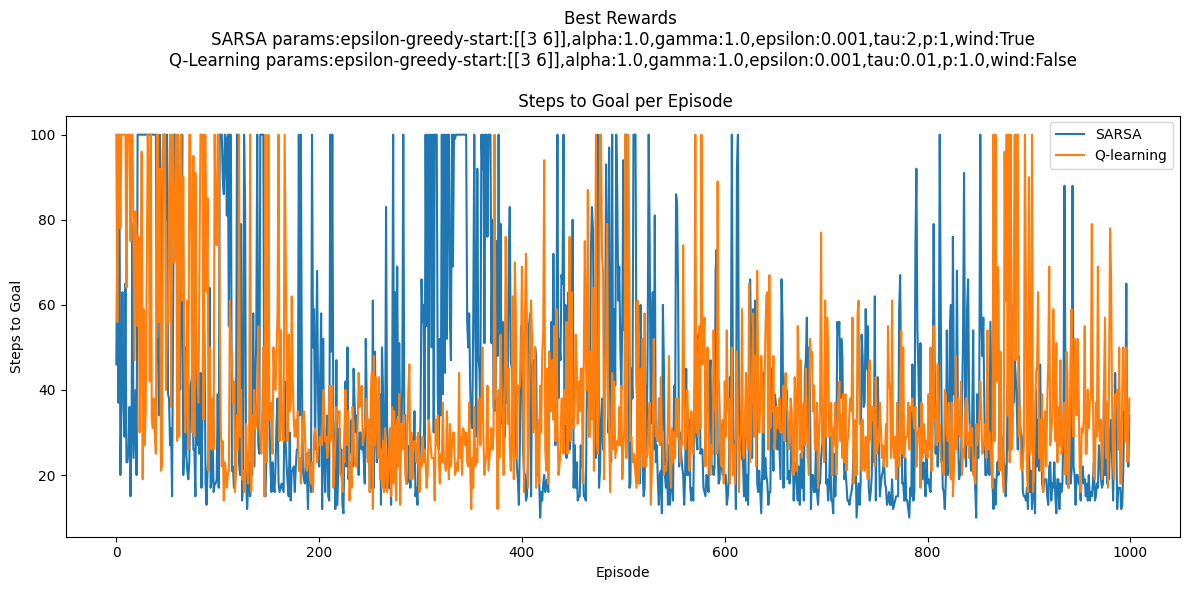

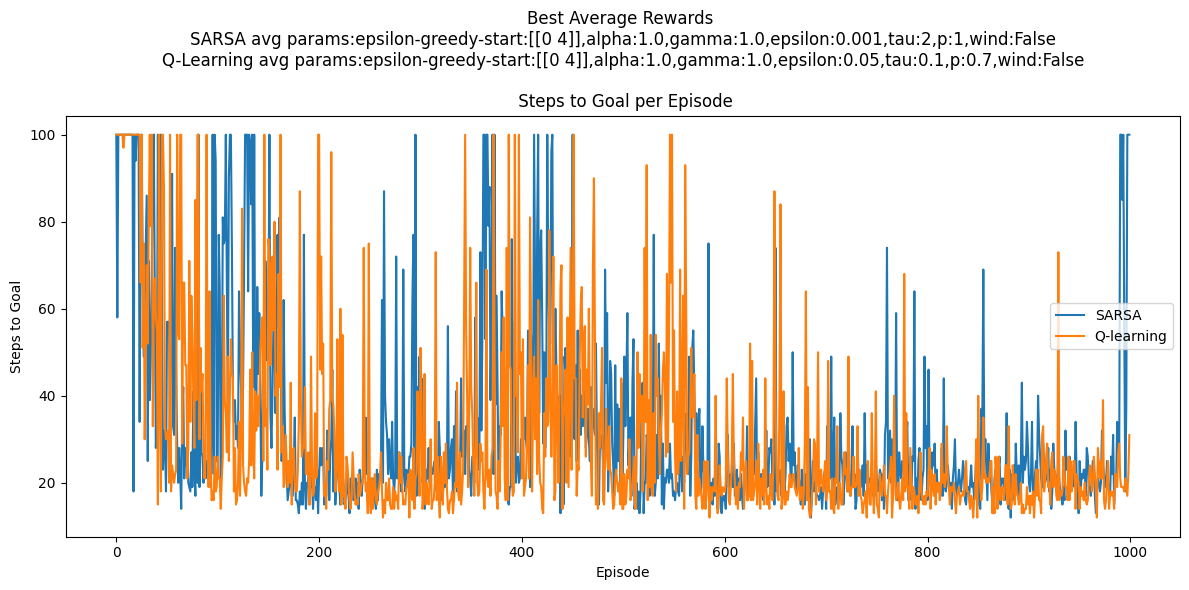

In [12]:
plot_steps(agent_sarsa, agent_qlearning, f"Best Rewards \nSARSA params:{sarsa_hyperparameters['exploration_strategy']}-start:{sarsa_hyperparameters['start_state']},alpha:{sarsa_hyperparameters['alpha']},gamma:{sarsa_hyperparameters['gamma']},epsilon:{sarsa_hyperparameters['epsilon']},tau:{sarsa_hyperparameters['tau']},p:{sarsa_hyperparameters['p']},wind:{sarsa_hyperparameters['wind']}\nQ-Learning params:{qlearning_hyperparameters['exploration_strategy']}-start:{qlearning_hyperparameters['start_state']},alpha:{qlearning_hyperparameters['alpha']},gamma:{qlearning_hyperparameters['gamma']},epsilon:{qlearning_hyperparameters['epsilon']},tau:{qlearning_hyperparameters['tau']},p:{qlearning_hyperparameters['p']},wind:{qlearning_hyperparameters['wind']}\n\n")

plot_steps(agent_avg_sarsa, agent_avg_qlearning, f"Best Average Rewards \nSARSA avg params:{sarsa_avg_hyperparameters['exploration_strategy']}-start:{sarsa_avg_hyperparameters['start_state']},alpha:{sarsa_avg_hyperparameters['alpha']},gamma:{sarsa_avg_hyperparameters['gamma']},epsilon:{sarsa_avg_hyperparameters['epsilon']},tau:{sarsa_avg_hyperparameters['tau']},p:{sarsa_avg_hyperparameters['p']},wind:{sarsa_avg_hyperparameters['wind']}\nQ-Learning avg params:{qlearning_avg_hyperparameters['exploration_strategy']}-start:{qlearning_avg_hyperparameters['start_state']},alpha:{qlearning_avg_hyperparameters['alpha']},gamma:{qlearning_avg_hyperparameters['gamma']},epsilon:{qlearning_avg_hyperparameters['epsilon']},tau:{qlearning_avg_hyperparameters['tau']},p:{qlearning_avg_hyperparameters['p']},wind:{qlearning_avg_hyperparameters['wind']}\n\n")

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

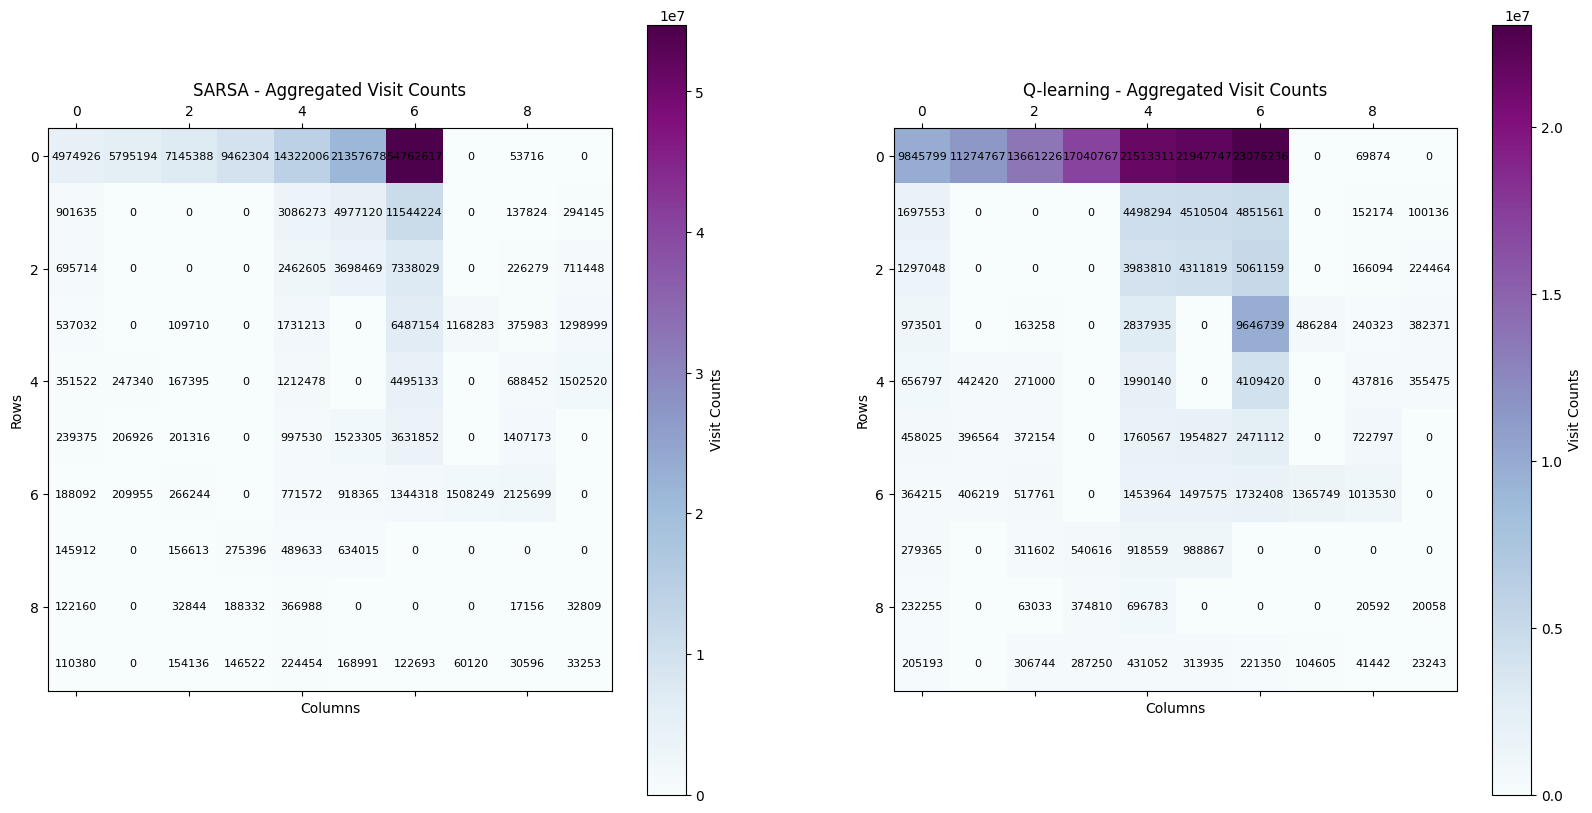

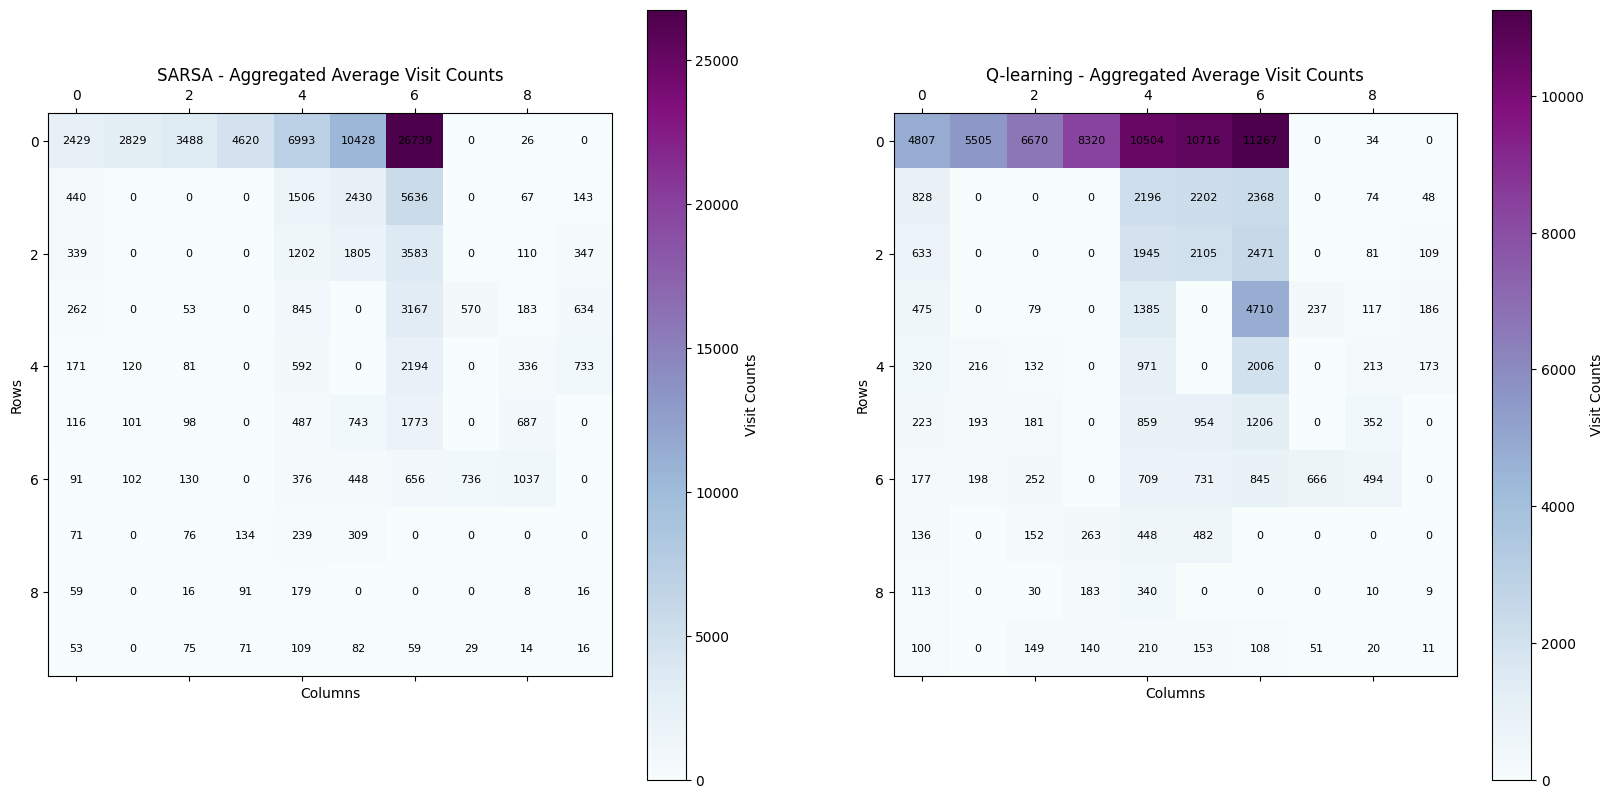

In [13]:
plot_heatmap(sarsa_visit_count, qlearning_visit_count, "Aggregated Visit Counts")
plot_heatmap(sarsa_visit_average,qlearning_visit_average, "Aggregated Average Visit Counts")

plot_visit_counts(agent_sarsa, agent_qlearning, "Best Rewards Visit Path")
plot_visit_counts(agent_avg_sarsa, agent_avg_qlearning, "Best Average Rewards Visit Path")

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

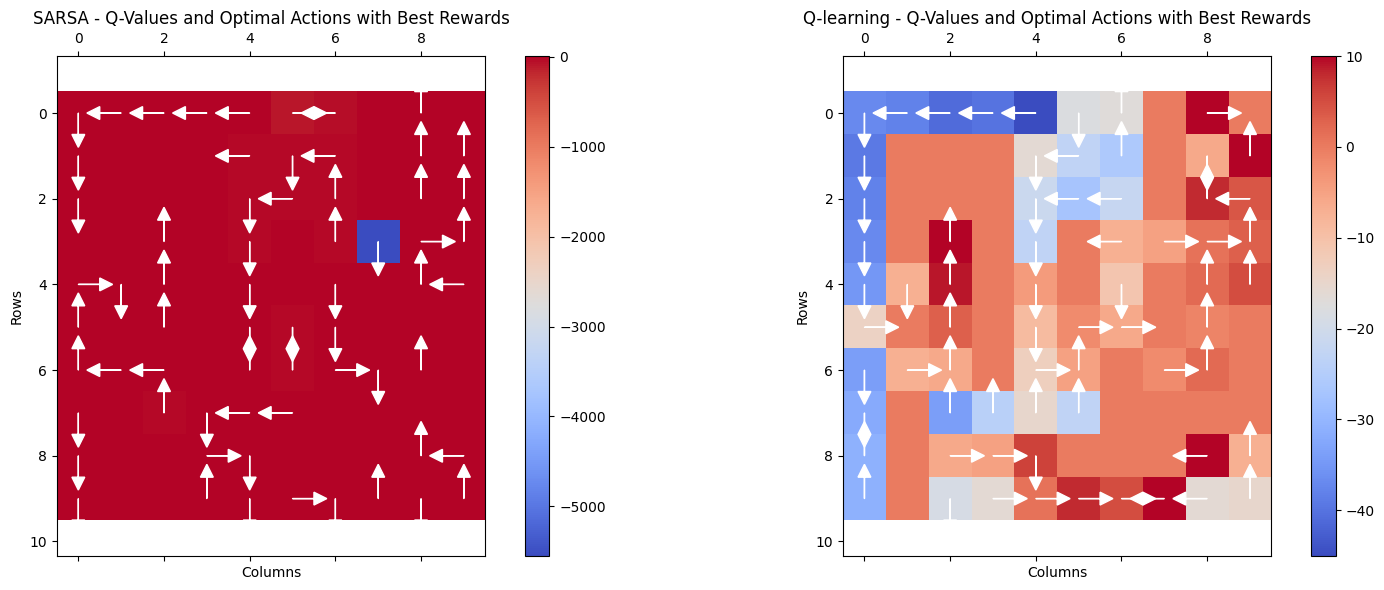

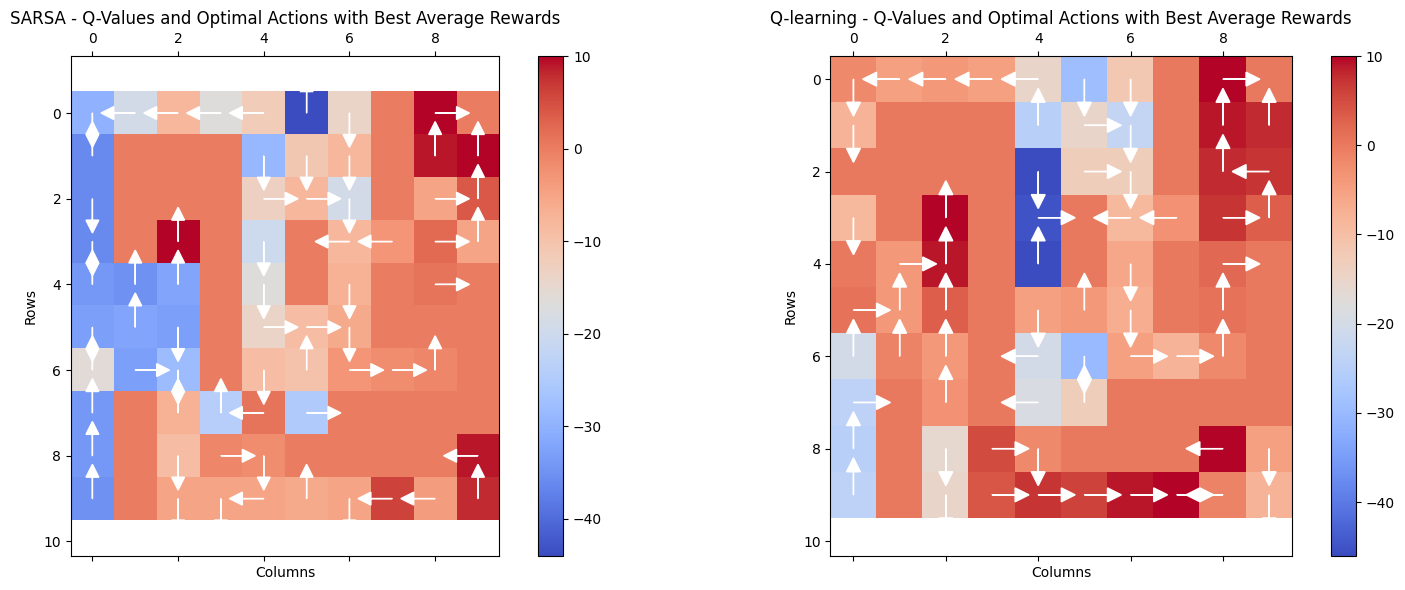

In [14]:
plot_q_values_and_optimal_actions(agent_sarsa, agent_qlearning, f'Q-Values and Optimal Actions with Best Rewards')

plot_q_values_and_optimal_actions(agent_avg_sarsa, agent_avg_qlearning, f'Q-Values and Optimal Actions with Best Average Rewards')

## Analysis [36 Marks]

### Analysis with wind for both starting state in SARSA and Q-Learning

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_37634/2130979137.py:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_37634/1662647722.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_37634/1662647722.py:55: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best Hyperparameters SARSA: {'start_state': array([[3, 6]]), 'alpha': 1, 'gamma': 1.0, 'epsilon': 0.001, 'tau': 0, 'p': 1, 'wind': True, 'exploration_strategy': 'epsilon-greedy', 'algorithm': 'SARSA'}
Best Rewards SARSA: -1.0
Best Agent SARSA: <__main__.RLAgent object at 0x138457390>
Best Average Hyperpar

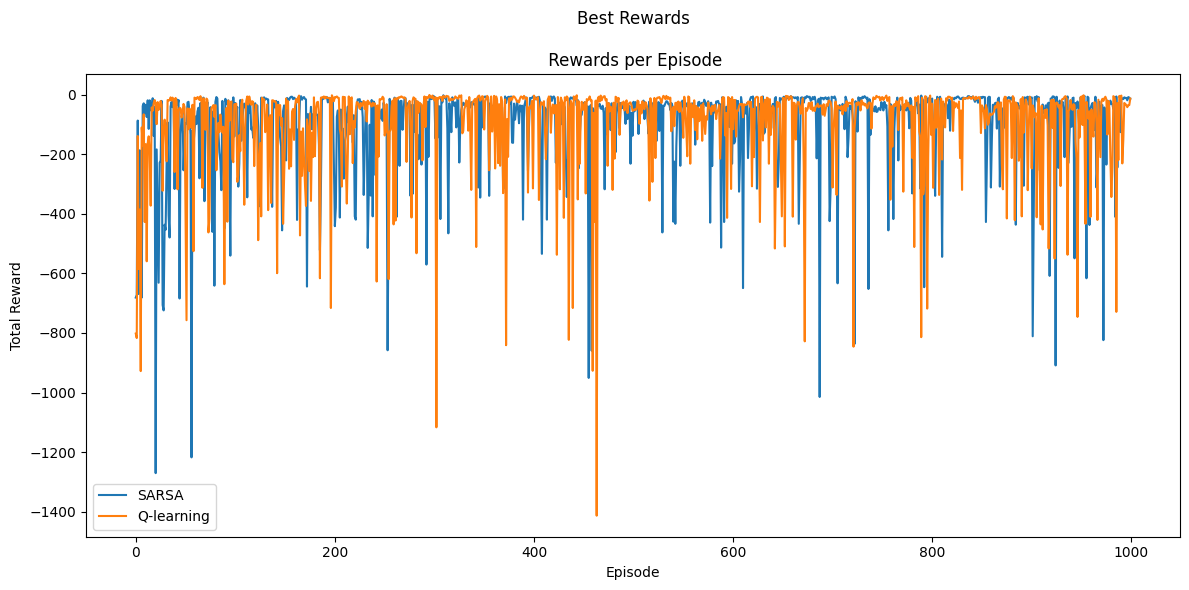

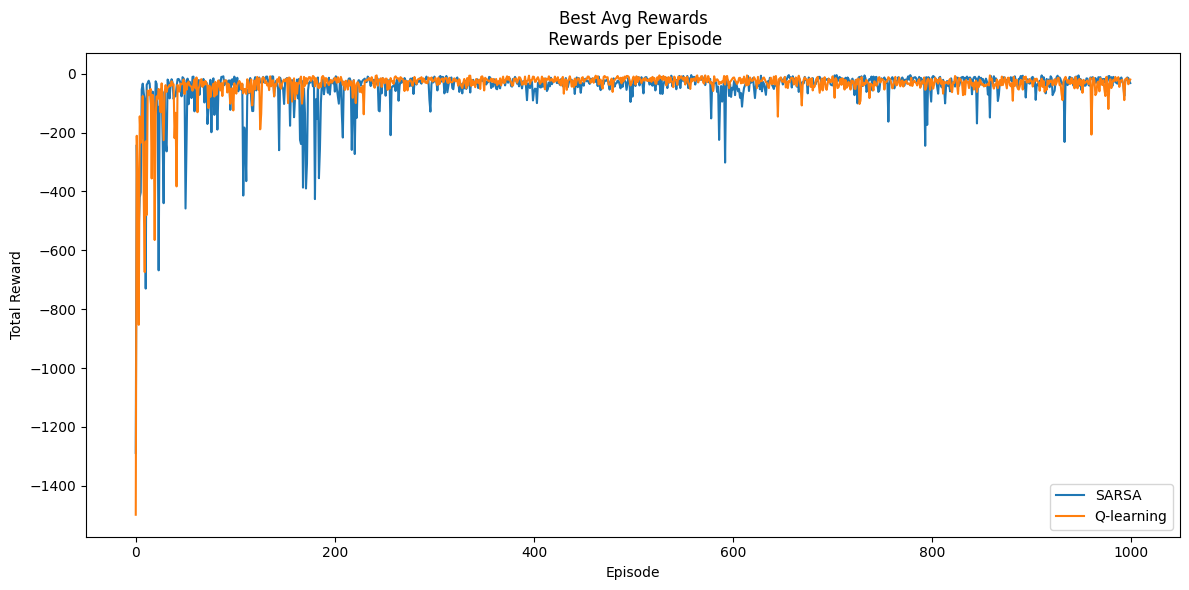

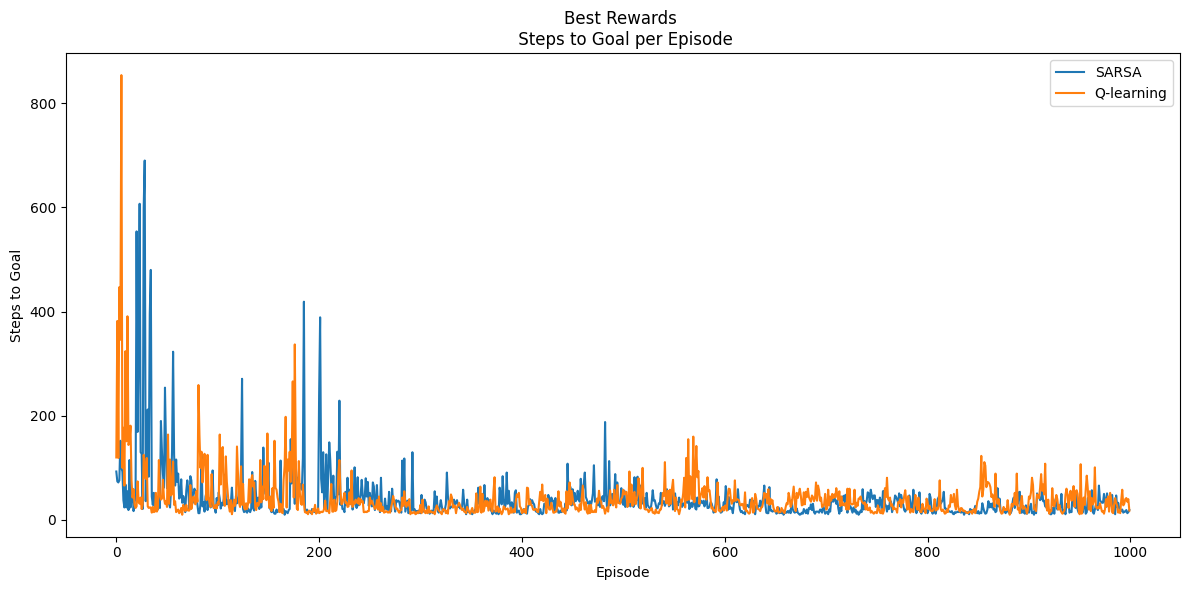

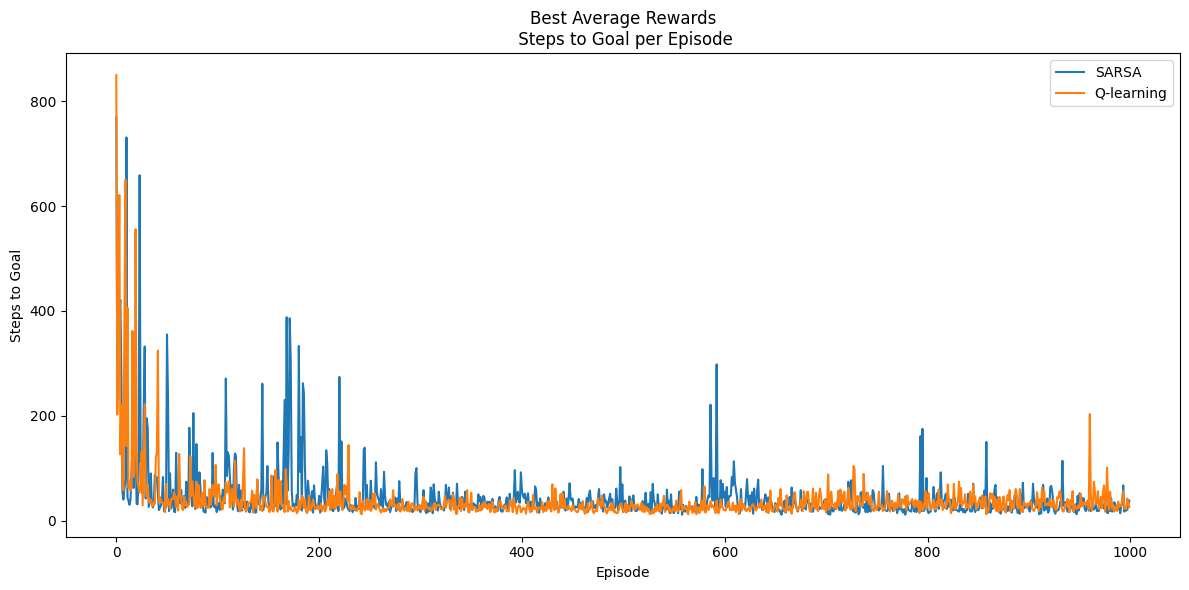

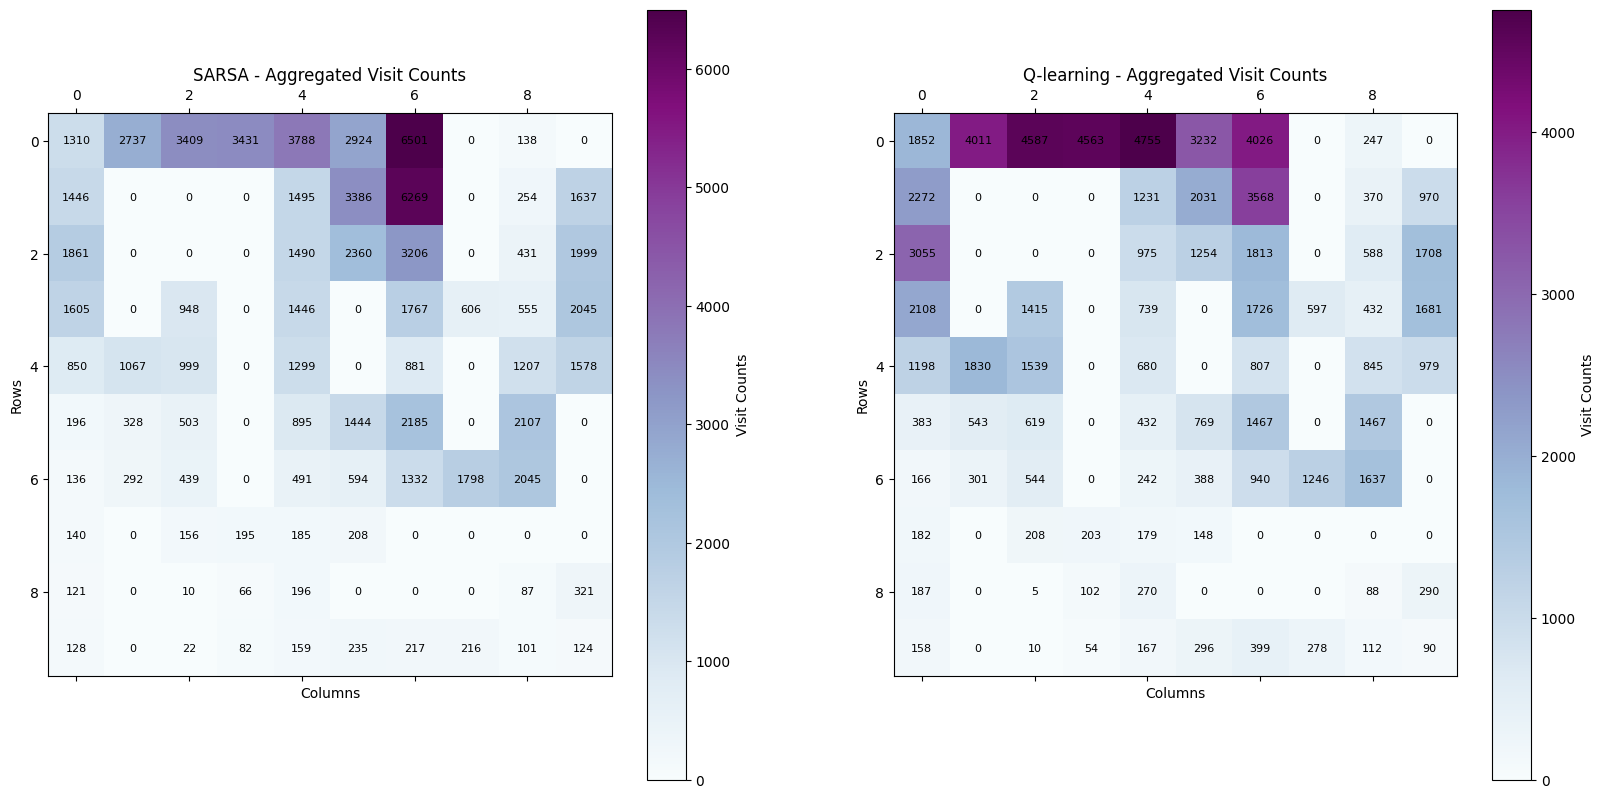

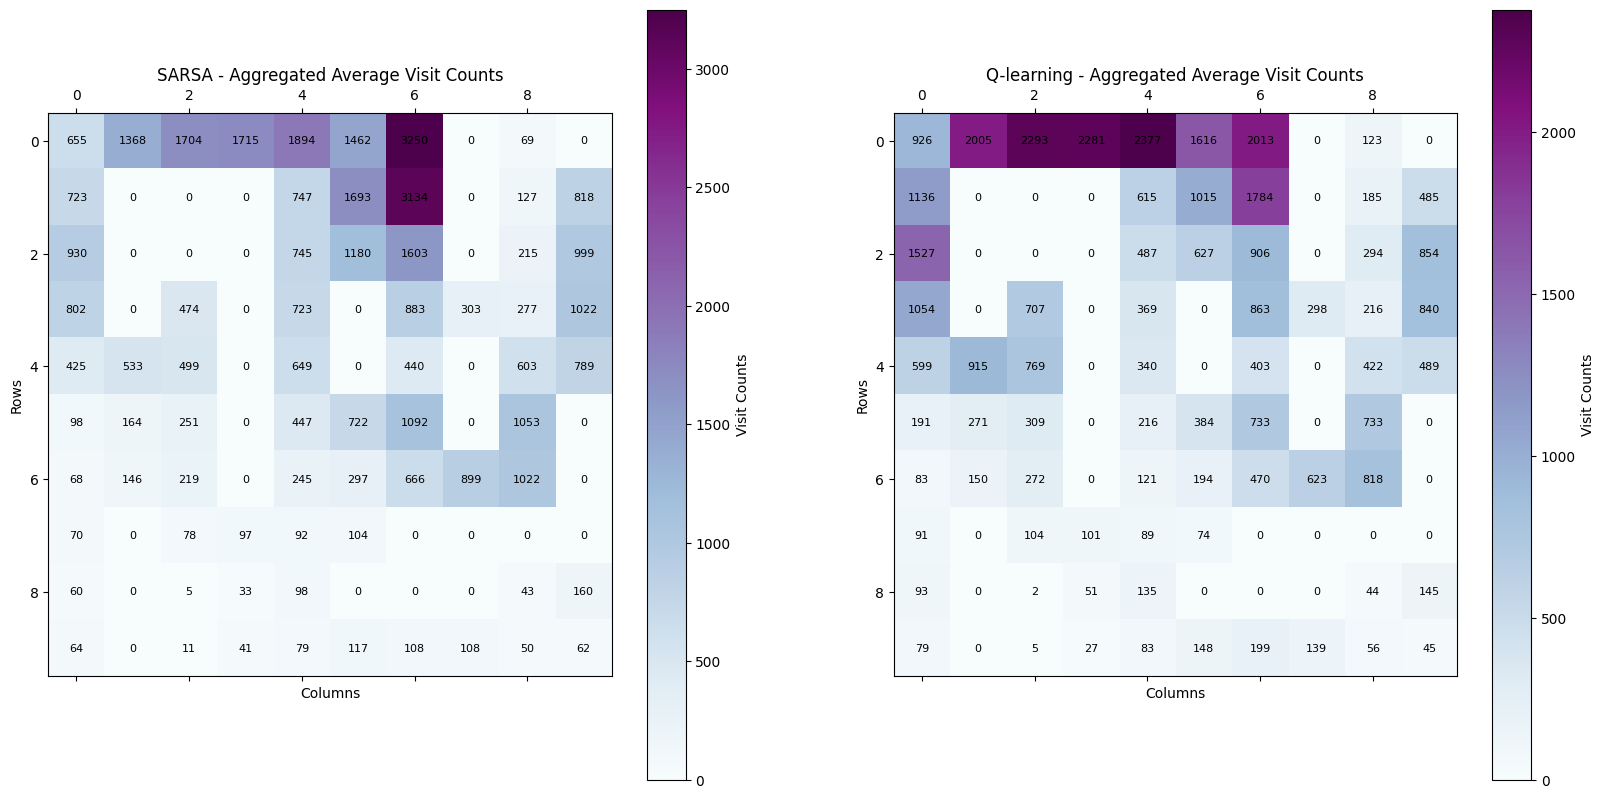

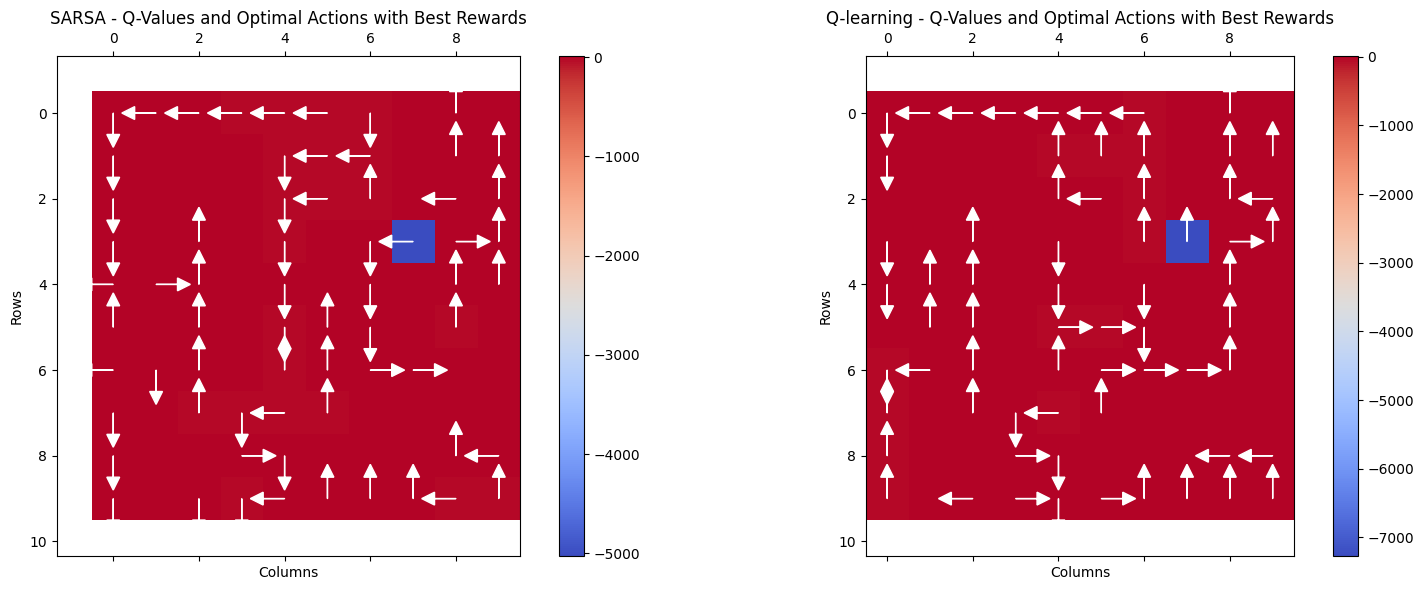

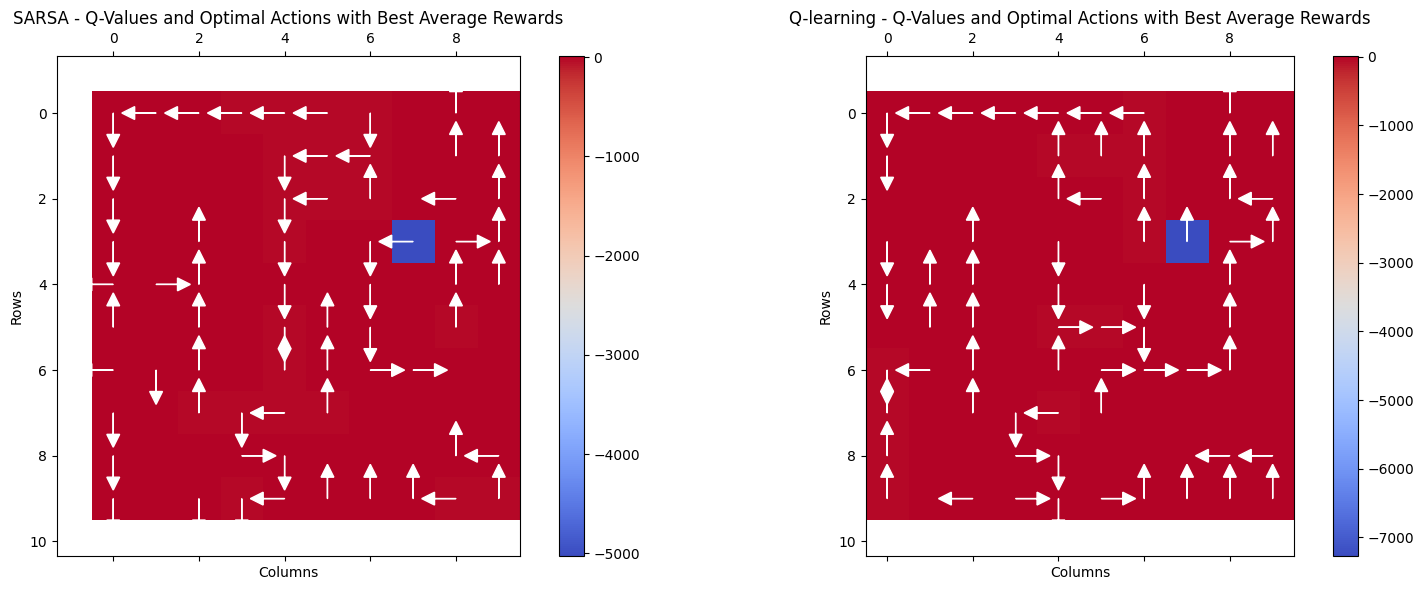

In [12]:
# Configurations
sarsa_param_grid = {
    'start_state': [[0, 4],[3, 6]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1], 
    'wind': [True],  
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['SARSA']
}

qlearning_param_grid = {
    'start_state': [[0, 4],[3, 6]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1.0],
    'wind': [True], 
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['Q-Learning']
}

param_grids = [sarsa_param_grid, qlearning_param_grid]
configurations = [config for grid in param_grids for config in ParameterGrid(grid)]

max_steps = 1000
n_agents = 50
episodes = 1000

# Best Hyperparameters and best rewards
best_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_rewards = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_agent = {'SARSA': {}, 'Q-Learning': {}}

# Best average Hyperparameters and best average rewards
best_avg_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_avg_reward = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_avg_agent = {'SARSA': {}, 'Q-Learning': {}}

# Aggregated visit counts
aggregated_visit_counts = {'SARSA': np.zeros((env.num_rows, env.num_cols)).astype(int), 'Q-Learning': np.zeros((env.num_rows, env.num_cols)).astype(int)}
n = {'SARSA': 0, 'Q-Learning': 0}

def calculate_best_parameters(agent: RLAgent):
    algorithm  = agent.get_algorithm()
    aggregated_visit_counts[algorithm] += agent.get_visit_counts()
    hyperparameters = agent.get_hyperparameters()
    n[algorithm] += 1
    best_reward = max(agent.episode_rewards)
    avg_reward = np.mean(agent.episode_rewards)

    if avg_reward > best_avg_reward[algorithm]:
        best_avg_reward[algorithm] = avg_reward
        best_avg_hyperparameters[algorithm] = hyperparameters
        best_avg_agent[algorithm] = agent

    if best_reward > best_rewards[algorithm]:
        best_rewards[algorithm] = best_reward
        best_hyperparameters[algorithm] = hyperparameters
        best_agent[algorithm] = agent
    
def run_training(config):
    start_state = config['start_state']
    alpha = config['alpha']
    gamma = config['gamma']
    epsilon = config['epsilon']
    tau = config['tau']
    p = config['p']
    wind = config['wind']
    exploration_strategy = config['exploration_strategy']
    algorithm = config['algorithm']

    # size of the grid
    num_cols = 10
    num_rows = 10

    # coordinates of the cells representing obstruction
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

    # list of bad states
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

    # list of restart states
    restart_states = np.array([[3,7],[8,2]])

    # starting position
    start_state = np.array([start_state])

    # list of goal states i.e. terminal states
    goal_states = np.array([[0,9],[2,2],[8,7]])

    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind)

    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)

    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)
    env = gw.create_gridworld()

    agent = train_agent(env, start_state, wind, alpha, gamma, epsilon, tau, p, episodes=episodes, max_steps=max_steps, algorithm=algorithm, exploration_strategy=exploration_strategy)
    calculate_best_parameters(agent)
    return agent

expanded_configurations = [config for config in configurations for _ in range(n_agents)]

with ThreadPoolExecutor(max_workers=n_agents) as executor:
    results = list(tqdm(executor.map(run_training, configurations), total=len(configurations)))

agent_sarsa = best_agent['SARSA']
sarsa_hyperparameters = best_hyperparameters['SARSA']
sarsa_best_rewards = best_rewards['SARSA']

agent_qlearning = best_agent['Q-Learning']
qlearning_hyperparameters = best_hyperparameters['Q-Learning']
qlearning_best_rewards = best_rewards['Q-Learning']

agent_avg_sarsa = best_avg_agent['SARSA']
sarsa_avg_hyperparameters = best_avg_hyperparameters['SARSA']
sarsa_avg_rewards = best_avg_reward['SARSA']

agent_avg_qlearning = best_avg_agent['Q-Learning']
qlearning_avg_hyperparameters = best_avg_hyperparameters['Q-Learning']
qlearning_avg_rewards = best_avg_reward['Q-Learning']

sarsa_visit_count = aggregated_visit_counts['SARSA']
qlearning_visit_count = aggregated_visit_counts['Q-Learning']

sarsa_visit_average = np.divide(aggregated_visit_counts['SARSA'], n['SARSA']).astype(int)
qlearning_visit_average = np.divide(aggregated_visit_counts['Q-Learning'], n['Q-Learning']).astype(int)

q_values_sarsa, optimal_actions_sarsa = agent_sarsa.get_optimal_policy_and_q_values()
q_values_qlearning, optimal_actions_qlearning = agent_qlearning.get_optimal_policy_and_q_values()

print("Best Hyperparameters SARSA:", sarsa_hyperparameters)
print("Best Rewards SARSA:", sarsa_best_rewards)
print("Best Agent SARSA:", agent_sarsa)
print("Best Average Hyperparameters SARSA:", sarsa_avg_hyperparameters)
print("Best Average Rewards SARSA:", sarsa_avg_rewards)
print("Best Average Agent SARSA:", agent_avg_sarsa)
print("Sarsa Visit Count", sarsa_visit_count)
print("Sarsa Visit Count average", sarsa_visit_average)

print("Best Hyperparameters Q-Learning:", qlearning_hyperparameters)
print("Best Rewards Q-Learning:", qlearning_best_rewards)
print("Best Agent Q-Learning:", agent_qlearning)
print("Best Average Hyperparameters Q-Learning:", qlearning_avg_hyperparameters)
print("Best Average Rewards Q-Learning:", qlearning_avg_rewards)
print("Best Average Agent Q-Learning:", agent_avg_qlearning)
print("Q-Learning Visit Count", qlearning_visit_count)
print("Q-Learning Visit Count average", qlearning_visit_average)

print("n_sarsa:", n['SARSA'])
print("n_Q-Learning:", n['Q-Learning'])

print("Q-value SARSA:", q_values_sarsa)
print("Q-value Q-learning:", q_values_qlearning)

print("Optimal Actions SARSA:", optimal_actions_sarsa)
print("Optimal Actions Q-Learning:", optimal_actions_qlearning)

plot_rewards(agent_sarsa, agent_qlearning, f"Best Rewards\n\n")
plot_rewards(agent_avg_sarsa, agent_avg_qlearning, f"Best Avg Rewards\n")

plot_steps(agent_sarsa, agent_qlearning, f"Best Rewards \n")
plot_steps(agent_avg_sarsa, agent_avg_qlearning, f"Best Average Rewards\n")

plot_heatmap(sarsa_visit_count, qlearning_visit_count, "Aggregated Visit Counts")
plot_heatmap(sarsa_visit_average,qlearning_visit_average, "Aggregated Average Visit Counts")

plot_visit_counts(agent_sarsa, agent_qlearning, "Best Rewards Visit Path")
plot_visit_counts(agent_avg_sarsa, agent_avg_qlearning, "Best Average Rewards Visit Path")

plot_q_values_and_optimal_actions(agent_sarsa, agent_qlearning, f'Q-Values and Optimal Actions with Best Rewards')
plot_q_values_and_optimal_actions(agent_avg_sarsa, agent_avg_qlearning, f'Q-Values and Optimal Actions with Best Average Rewards')

### Analysis without wind for both starting state in SARSA and Q-Learning

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_37634/2130979137.py:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_37634/1662647722.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_37634/1662647722.py:55: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best Hyperparameters SARSA: {'start_state': array([[3, 6]]), 'alpha': 1, 'gamma': 1.0, 'epsilon': 0.001, 'tau': 0, 'p': 1, 'wind': False, 'exploration_strategy': 'epsilon-greedy', 'algorithm': 'SARSA'}
Best Rewards SARSA: -1.0
Best Agent SARSA: <__main__.RLAgent object at 0x163d75550>
Best Average Hyperpa

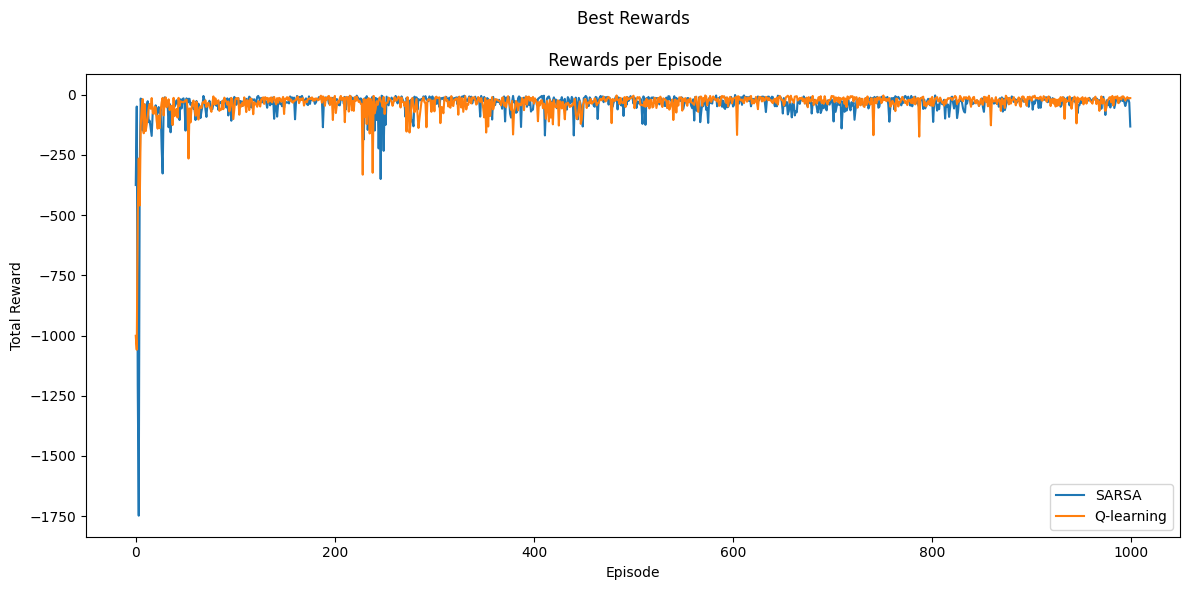

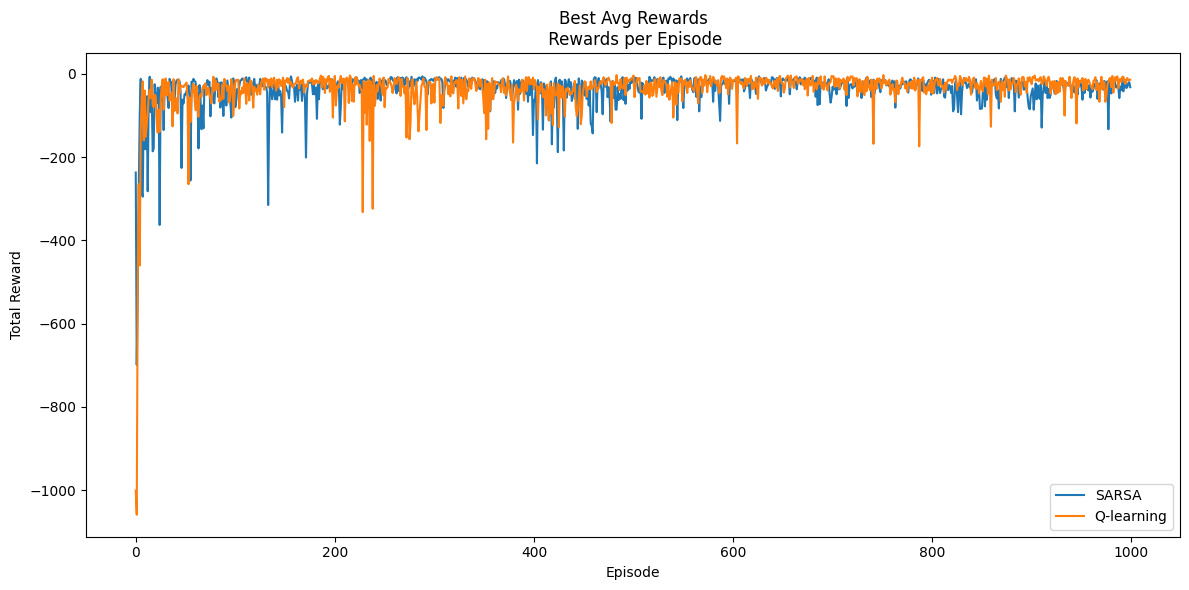

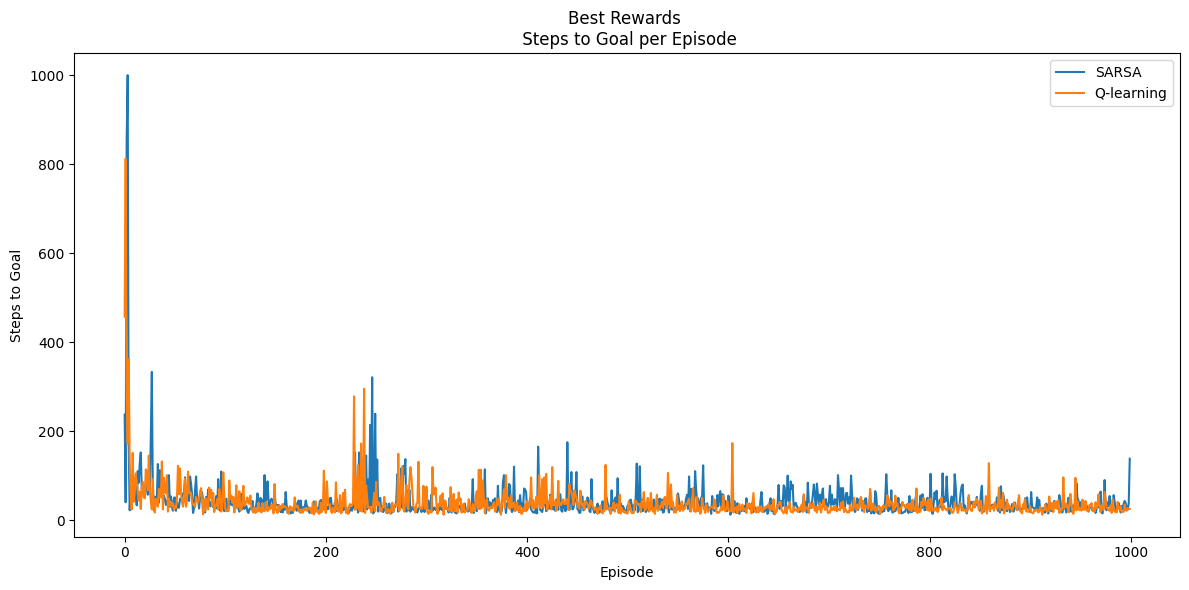

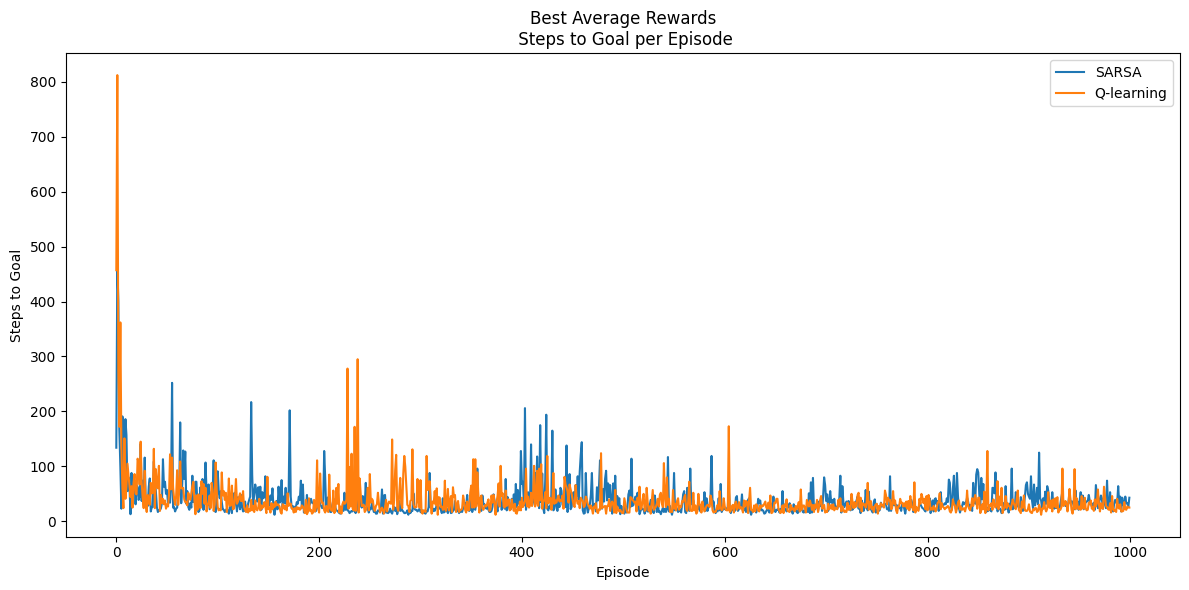

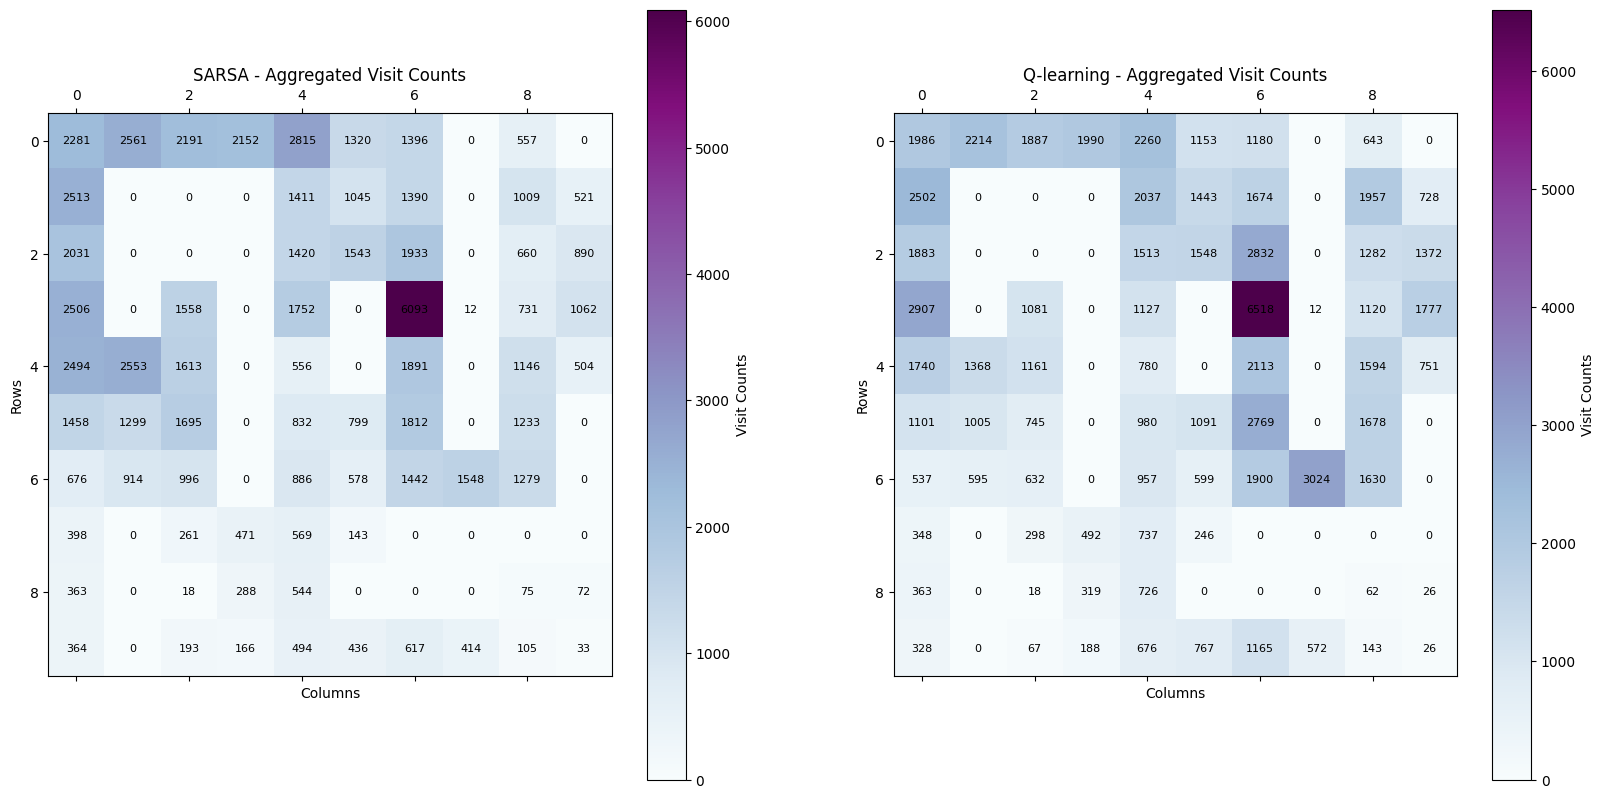

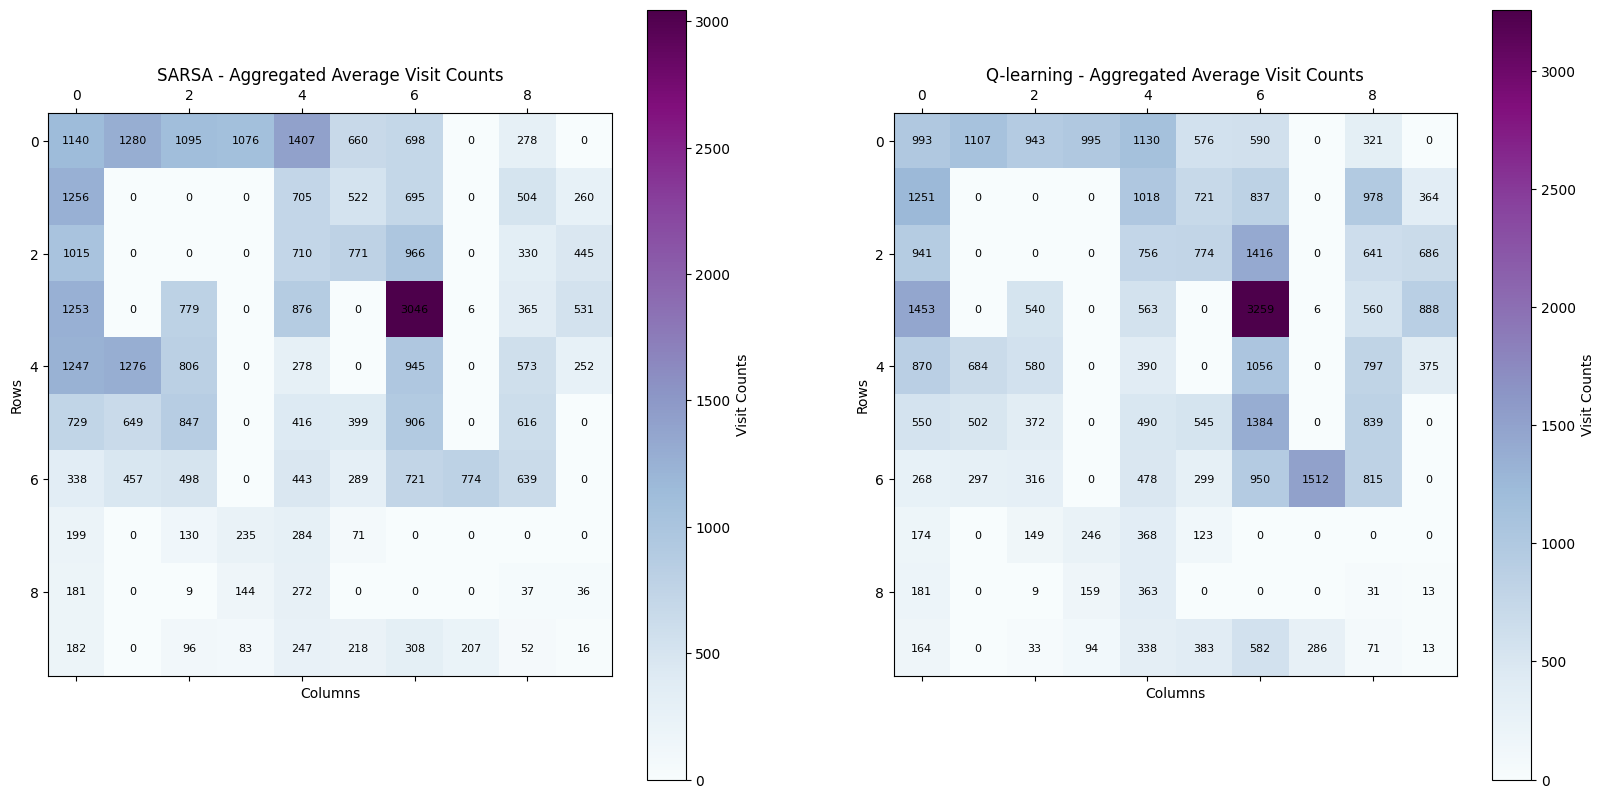

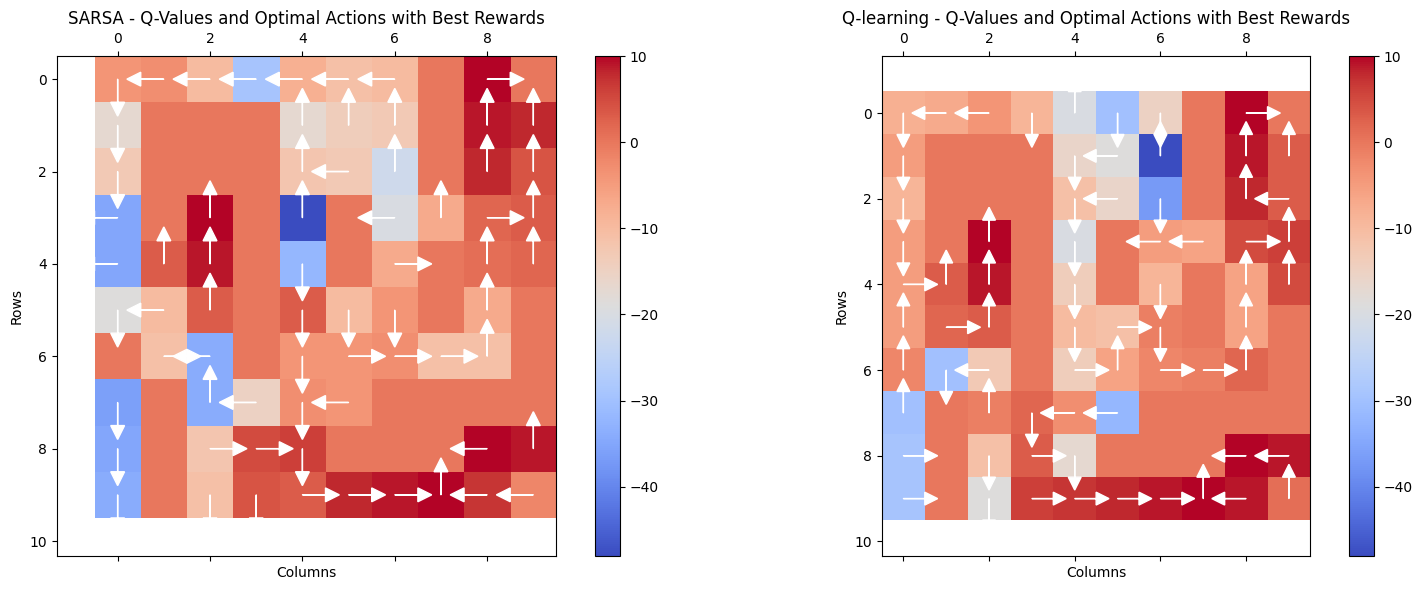

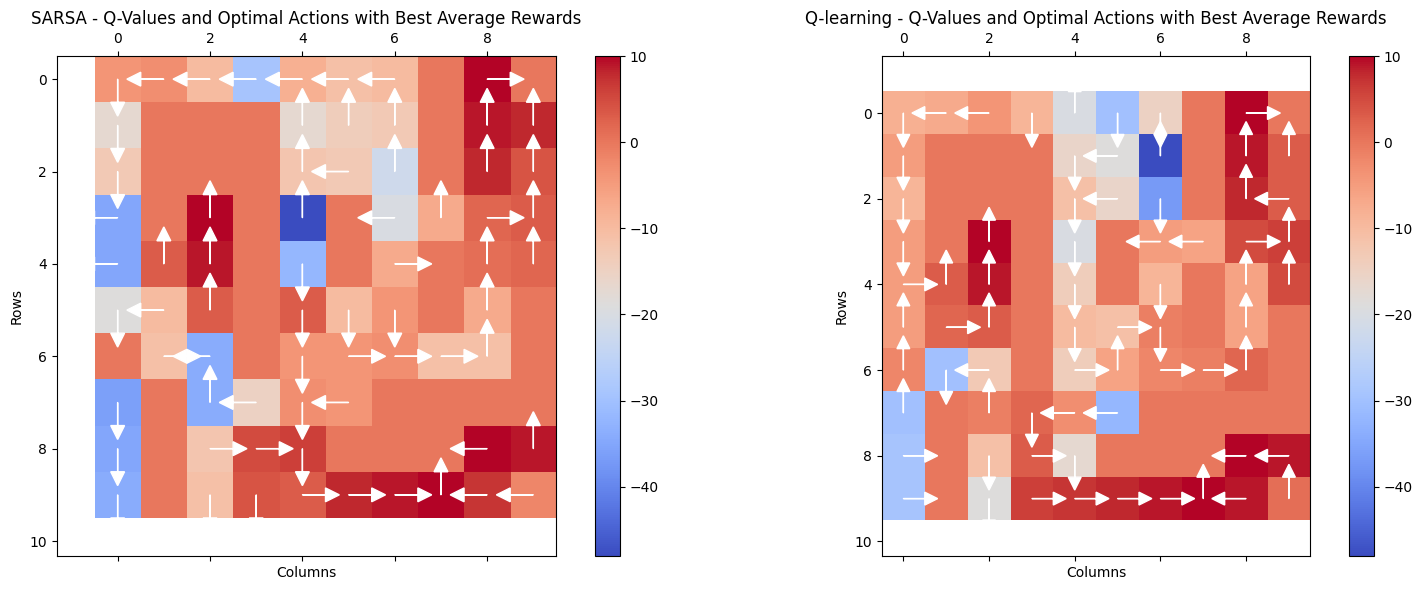

In [13]:
# Configurations
sarsa_param_grid = {
    'start_state': [[0, 4],[3, 6]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1],  # Specific p value for SARSA
    'wind': [False],  # Specific wind values for SARSA
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['SARSA']
}

qlearning_param_grid = {
    'start_state': [[0, 4],[3, 6]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1.0],  # Specific p value for Q-Learning
    'wind': [False],  # Specific wind values for Q-Learning
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['Q-Learning']
}

param_grids = [sarsa_param_grid, qlearning_param_grid]
configurations = [config for grid in param_grids for config in ParameterGrid(grid)]

max_steps = 1000
n_agents = 50
episodes = 1000

# Best Hyperparameters and best rewards
best_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_rewards = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_agent = {'SARSA': {}, 'Q-Learning': {}}

# Best average Hyperparameters and best average rewards
best_avg_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_avg_reward = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_avg_agent = {'SARSA': {}, 'Q-Learning': {}}

# Aggregated visit counts
aggregated_visit_counts = {'SARSA': np.zeros((env.num_rows, env.num_cols)).astype(int), 'Q-Learning': np.zeros((env.num_rows, env.num_cols)).astype(int)}
n = {'SARSA': 0, 'Q-Learning': 0}

def calculate_best_parameters(agent: RLAgent):
    algorithm  = agent.get_algorithm()
    aggregated_visit_counts[algorithm] += agent.get_visit_counts()
    hyperparameters = agent.get_hyperparameters()
    n[algorithm] += 1
    best_reward = max(agent.episode_rewards)
    avg_reward = np.mean(agent.episode_rewards)

    if avg_reward > best_avg_reward[algorithm]:
        best_avg_reward[algorithm] = avg_reward
        best_avg_hyperparameters[algorithm] = hyperparameters
        best_avg_agent[algorithm] = agent

    if best_reward > best_rewards[algorithm]:
        best_rewards[algorithm] = best_reward
        best_hyperparameters[algorithm] = hyperparameters
        best_agent[algorithm] = agent
    
def run_training(config):
    start_state = config['start_state']
    alpha = config['alpha']
    gamma = config['gamma']
    epsilon = config['epsilon']
    tau = config['tau']
    p = config['p']
    wind = config['wind']
    exploration_strategy = config['exploration_strategy']
    algorithm = config['algorithm']

    # size of the grid
    num_cols = 10
    num_rows = 10

    # coordinates of the cells representing obstruction
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

    # list of bad states
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

    # list of restart states
    restart_states = np.array([[3,7],[8,2]])

    # starting position
    start_state = np.array([start_state])

    # list of goal states i.e. terminal states
    goal_states = np.array([[0,9],[2,2],[8,7]])

    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind)

    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)

    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)
    env = gw.create_gridworld()

    agent = train_agent(env, start_state, wind, alpha, gamma, epsilon, tau, p, episodes=episodes, max_steps=max_steps, algorithm=algorithm, exploration_strategy=exploration_strategy)
    calculate_best_parameters(agent)
    return agent

expanded_configurations = [config for config in configurations for _ in range(n_agents)]

with ThreadPoolExecutor(max_workers=n_agents) as executor:
    results = list(tqdm(executor.map(run_training, configurations), total=len(configurations)))

agent_sarsa = best_agent['SARSA']
sarsa_hyperparameters = best_hyperparameters['SARSA']
sarsa_best_rewards = best_rewards['SARSA']

agent_qlearning = best_agent['Q-Learning']
qlearning_hyperparameters = best_hyperparameters['Q-Learning']
qlearning_best_rewards = best_rewards['Q-Learning']

agent_avg_sarsa = best_avg_agent['SARSA']
sarsa_avg_hyperparameters = best_avg_hyperparameters['SARSA']
sarsa_avg_rewards = best_avg_reward['SARSA']

agent_avg_qlearning = best_avg_agent['Q-Learning']
qlearning_avg_hyperparameters = best_avg_hyperparameters['Q-Learning']
qlearning_avg_rewards = best_avg_reward['Q-Learning']

sarsa_visit_count = aggregated_visit_counts['SARSA']
qlearning_visit_count = aggregated_visit_counts['Q-Learning']

sarsa_visit_average = np.divide(aggregated_visit_counts['SARSA'], n['SARSA']).astype(int)
qlearning_visit_average = np.divide(aggregated_visit_counts['Q-Learning'], n['Q-Learning']).astype(int)

q_values_sarsa, optimal_actions_sarsa = agent_sarsa.get_optimal_policy_and_q_values()
q_values_qlearning, optimal_actions_qlearning = agent_qlearning.get_optimal_policy_and_q_values()

print("Best Hyperparameters SARSA:", sarsa_hyperparameters)
print("Best Rewards SARSA:", sarsa_best_rewards)
print("Best Agent SARSA:", agent_sarsa)
print("Best Average Hyperparameters SARSA:", sarsa_avg_hyperparameters)
print("Best Average Rewards SARSA:", sarsa_avg_rewards)
print("Best Average Agent SARSA:", agent_avg_sarsa)
print("Sarsa Visit Count", sarsa_visit_count)
print("Sarsa Visit Count average", sarsa_visit_average)

print("Best Hyperparameters Q-Learning:", qlearning_hyperparameters)
print("Best Rewards Q-Learning:", qlearning_best_rewards)
print("Best Agent Q-Learning:", agent_qlearning)
print("Best Average Hyperparameters Q-Learning:", qlearning_avg_hyperparameters)
print("Best Average Rewards Q-Learning:", qlearning_avg_rewards)
print("Best Average Agent Q-Learning:", agent_avg_qlearning)
print("Q-Learning Visit Count", qlearning_visit_count)
print("Q-Learning Visit Count average", qlearning_visit_average)

print("n_sarsa:", n['SARSA'])
print("n_Q-Learning:", n['Q-Learning'])

print("Q-value SARSA:", q_values_sarsa)
print("Q-value Q-learning:", q_values_qlearning)

print("Optimal Actions SARSA:", optimal_actions_sarsa)
print("Optimal Actions Q-Learning:", optimal_actions_qlearning)

plot_rewards(agent_sarsa, agent_qlearning, f"Best Rewards\n\n")
plot_rewards(agent_avg_sarsa, agent_avg_qlearning, f"Best Avg Rewards\n")

plot_steps(agent_sarsa, agent_qlearning, f"Best Rewards \n")
plot_steps(agent_avg_sarsa, agent_avg_qlearning, f"Best Average Rewards\n")

plot_heatmap(sarsa_visit_count, qlearning_visit_count, "Aggregated Visit Counts")
plot_heatmap(sarsa_visit_average,qlearning_visit_average, "Aggregated Average Visit Counts")

plot_visit_counts(agent_sarsa, agent_qlearning, "Best Rewards Visit Path")
plot_visit_counts(agent_avg_sarsa, agent_avg_qlearning, "Best Average Rewards Visit Path")

plot_q_values_and_optimal_actions(agent_sarsa, agent_qlearning, f'Q-Values and Optimal Actions with Best Rewards')
plot_q_values_and_optimal_actions(agent_avg_sarsa, agent_avg_qlearning, f'Q-Values and Optimal Actions with Best Average Rewards')

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_27815/2130979137.py:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_27815/1662647722.py:55: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_27815/1662647722.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best Hyperparameters SARSA: {'start_state': array([[0, 4]]), 'alpha': 1, 'gamma': 1.0, 'epsilon': 0.001, 'tau': 0, 'p': 1, 'wind': True, 'exploration_strategy': 'epsilon-greedy', 'algorithm': 'SARSA'}
Best Rewards SARSA: -6.0
Best Agent SARSA: <__main__.RLAgent object at 0x153d33210>
Best Average Hyperpar

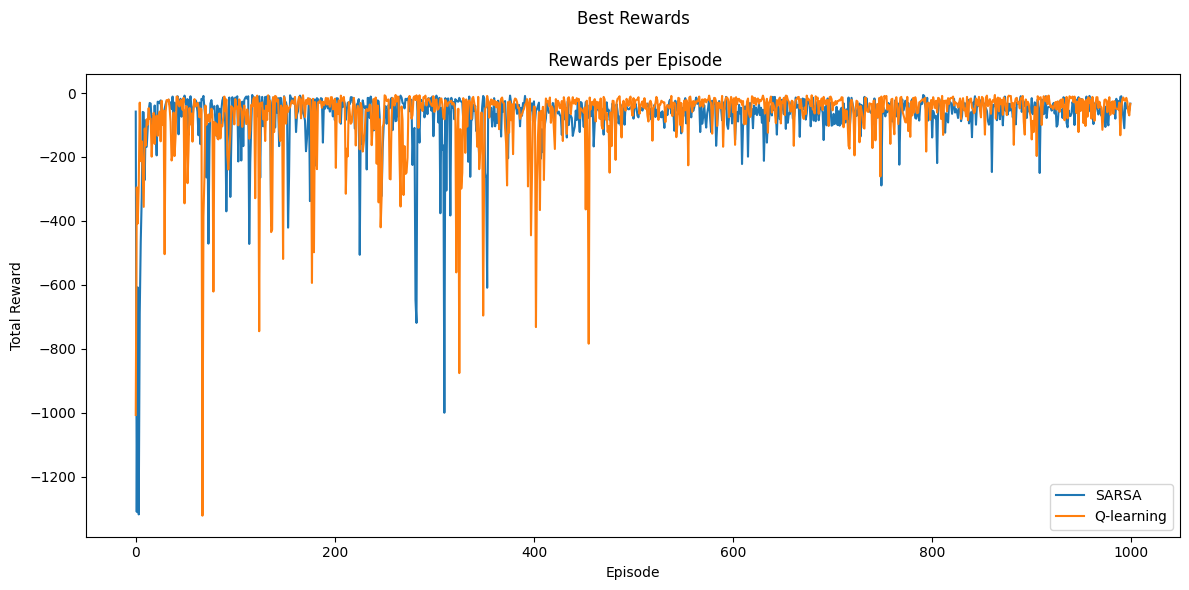

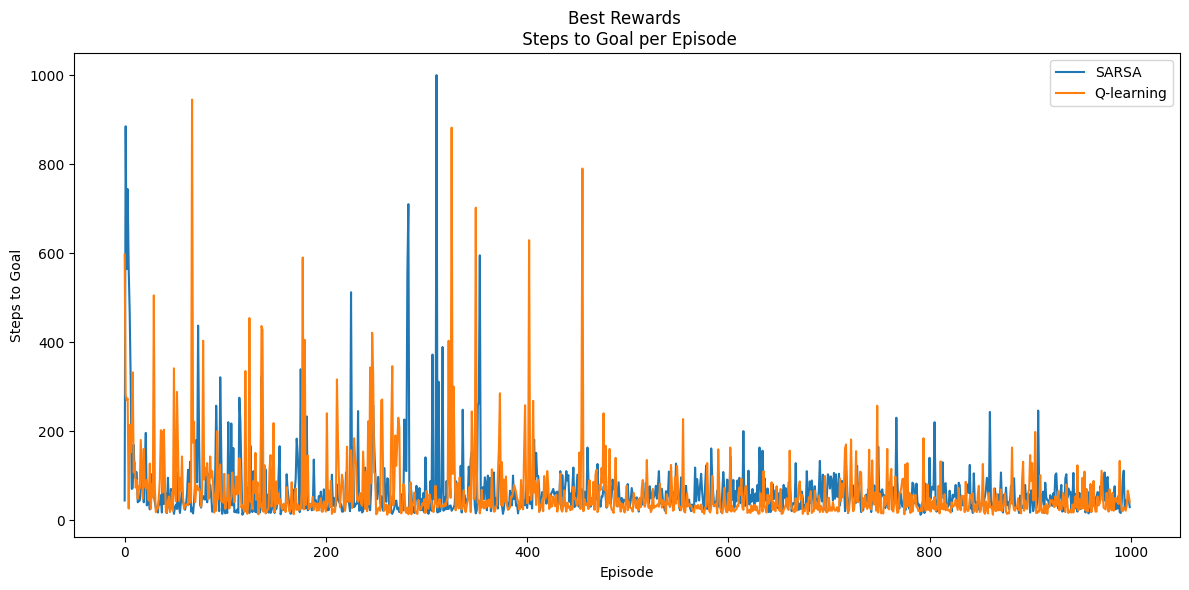

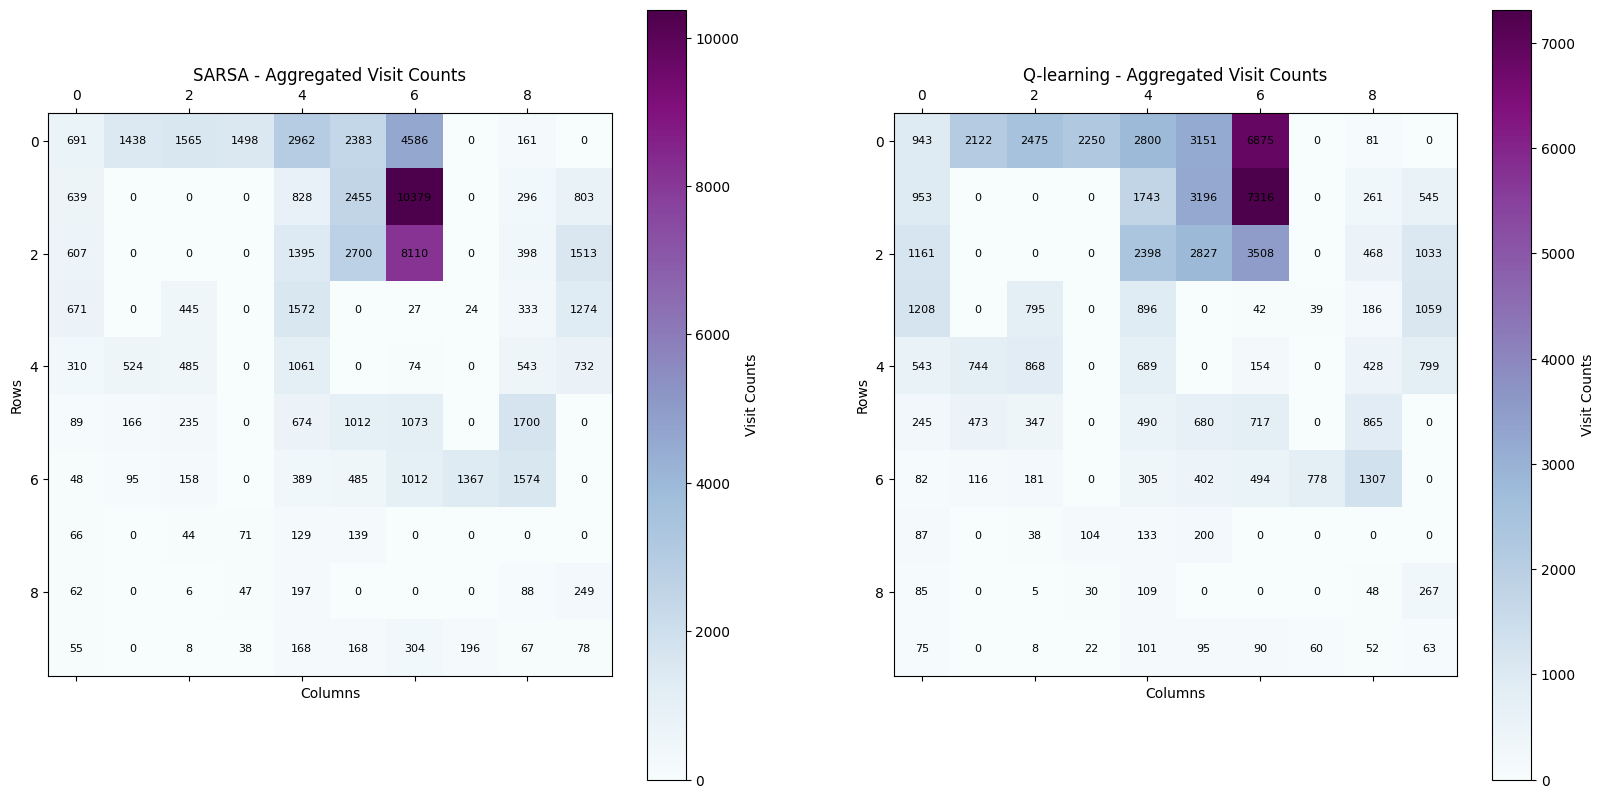

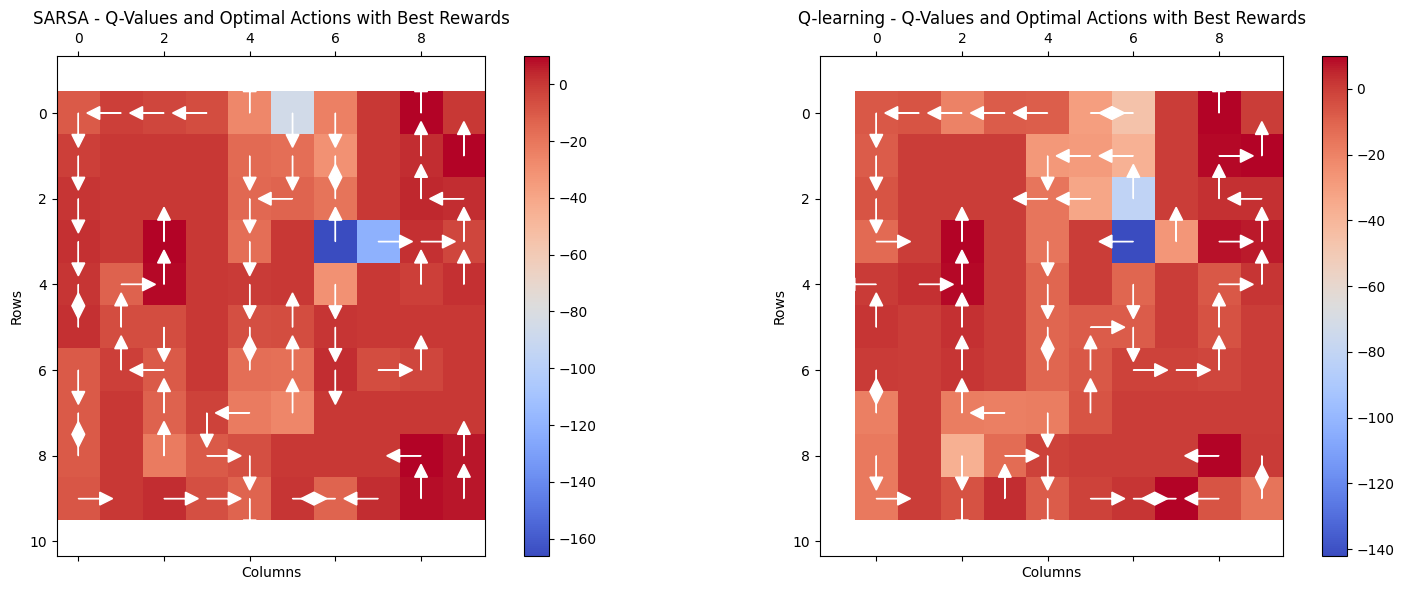

In [14]:
# Configurations
sarsa_param_grid = {
    'start_state': [[0, 4]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1],  # Specific p value for SARSA
    'wind': [True],  # Specific wind values for SARSA
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['SARSA']
}

qlearning_param_grid = {
    'start_state': [[0, 4]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1.0],  # Specific p value for Q-Learning
    'wind': [True],  # Specific wind values for Q-Learning
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['Q-Learning']
}

param_grids = [sarsa_param_grid, qlearning_param_grid]
configurations = [config for grid in param_grids for config in ParameterGrid(grid)]

max_steps = 1000
n_agents = 50
episodes = 1000

# Best Hyperparameters and best rewards
best_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_rewards = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_agent = {'SARSA': {}, 'Q-Learning': {}}

# Best average Hyperparameters and best average rewards
best_avg_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_avg_reward = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_avg_agent = {'SARSA': {}, 'Q-Learning': {}}

# Aggregated visit counts
aggregated_visit_counts = {'SARSA': np.zeros((env.num_rows, env.num_cols)).astype(int), 'Q-Learning': np.zeros((env.num_rows, env.num_cols)).astype(int)}
n = {'SARSA': 0, 'Q-Learning': 0}

def calculate_best_parameters(agent: RLAgent):
    algorithm  = agent.get_algorithm()
    aggregated_visit_counts[algorithm] += agent.get_visit_counts()
    hyperparameters = agent.get_hyperparameters()
    n[algorithm] += 1
    best_reward = max(agent.episode_rewards)
    avg_reward = np.mean(agent.episode_rewards)

    if avg_reward > best_avg_reward[algorithm]:
        best_avg_reward[algorithm] = avg_reward
        best_avg_hyperparameters[algorithm] = hyperparameters
        best_avg_agent[algorithm] = agent

    if best_reward > best_rewards[algorithm]:
        best_rewards[algorithm] = best_reward
        best_hyperparameters[algorithm] = hyperparameters
        best_agent[algorithm] = agent
    
def run_training(config):
    start_state = config['start_state']
    alpha = config['alpha']
    gamma = config['gamma']
    epsilon = config['epsilon']
    tau = config['tau']
    p = config['p']
    wind = config['wind']
    exploration_strategy = config['exploration_strategy']
    algorithm = config['algorithm']

    # size of the grid
    num_cols = 10
    num_rows = 10

    # coordinates of the cells representing obstruction
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

    # list of bad states
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

    # list of restart states
    restart_states = np.array([[3,7],[8,2]])

    # starting position
    start_state = np.array([start_state])

    # list of goal states i.e. terminal states
    goal_states = np.array([[0,9],[2,2],[8,7]])

    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind)

    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)

    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)
    env = gw.create_gridworld()

    agent = train_agent(env, start_state, wind, alpha, gamma, epsilon, tau, p, episodes=episodes, max_steps=max_steps, algorithm=algorithm, exploration_strategy=exploration_strategy)
    calculate_best_parameters(agent)
    return agent

expanded_configurations = [config for config in configurations for _ in range(n_agents)]

with ThreadPoolExecutor(max_workers=n_agents) as executor:
    results = list(tqdm(executor.map(run_training, configurations), total=len(configurations)))

agent_sarsa = best_agent['SARSA']
sarsa_hyperparameters = best_hyperparameters['SARSA']
sarsa_best_rewards = best_rewards['SARSA']

agent_qlearning = best_agent['Q-Learning']
qlearning_hyperparameters = best_hyperparameters['Q-Learning']
qlearning_best_rewards = best_rewards['Q-Learning']

agent_avg_sarsa = best_avg_agent['SARSA']
sarsa_avg_hyperparameters = best_avg_hyperparameters['SARSA']
sarsa_avg_rewards = best_avg_reward['SARSA']

agent_avg_qlearning = best_avg_agent['Q-Learning']
qlearning_avg_hyperparameters = best_avg_hyperparameters['Q-Learning']
qlearning_avg_rewards = best_avg_reward['Q-Learning']

sarsa_visit_count = aggregated_visit_counts['SARSA']
qlearning_visit_count = aggregated_visit_counts['Q-Learning']

sarsa_visit_average = np.divide(aggregated_visit_counts['SARSA'], n['SARSA']).astype(int)
qlearning_visit_average = np.divide(aggregated_visit_counts['Q-Learning'], n['Q-Learning']).astype(int)

q_values_sarsa, optimal_actions_sarsa = agent_sarsa.get_optimal_policy_and_q_values()
q_values_qlearning, optimal_actions_qlearning = agent_qlearning.get_optimal_policy_and_q_values()

print("Best Hyperparameters SARSA:", sarsa_hyperparameters)
print("Best Rewards SARSA:", sarsa_best_rewards)
print("Best Agent SARSA:", agent_sarsa)
print("Best Average Hyperparameters SARSA:", sarsa_avg_hyperparameters)
print("Best Average Rewards SARSA:", sarsa_avg_rewards)
print("Best Average Agent SARSA:", agent_avg_sarsa)
print("Sarsa Visit Count", sarsa_visit_count)
print("Sarsa Visit Count average", sarsa_visit_average)

print("Best Hyperparameters Q-Learning:", qlearning_hyperparameters)
print("Best Rewards Q-Learning:", qlearning_best_rewards)
print("Best Agent Q-Learning:", agent_qlearning)
print("Best Average Hyperparameters Q-Learning:", qlearning_avg_hyperparameters)
print("Best Average Rewards Q-Learning:", qlearning_avg_rewards)
print("Best Average Agent Q-Learning:", agent_avg_qlearning)
print("Q-Learning Visit Count", qlearning_visit_count)
print("Q-Learning Visit Count average", qlearning_visit_average)

print("n_sarsa:", n['SARSA'])
print("n_Q-Learning:", n['Q-Learning'])

print("Q-value SARSA:", q_values_sarsa)
print("Q-value Q-learning:", q_values_qlearning)

print("Optimal Actions SARSA:", optimal_actions_sarsa)
print("Optimal Actions Q-Learning:", optimal_actions_qlearning)

plot_rewards(agent_sarsa, agent_qlearning, f"Best Rewards\n\n")
# plot_rewards(agent_avg_sarsa, agent_avg_qlearning, f"Best Avg Rewards\n")

plot_steps(agent_sarsa, agent_qlearning, f"Best Rewards \n")
# plot_steps(agent_avg_sarsa, agent_avg_qlearning, f"Best Average Rewards\n")

plot_heatmap(sarsa_visit_count, qlearning_visit_count, "Aggregated Visit Counts")
# plot_heatmap(sarsa_visit_average,qlearning_visit_average, "Aggregated Average Visit Counts")

plot_visit_counts(agent_sarsa, agent_qlearning, "Best Rewards Visit Path")
# plot_visit_counts(agent_avg_sarsa, agent_avg_qlearning, "Best Average Rewards Visit Path")

plot_q_values_and_optimal_actions(agent_sarsa, agent_qlearning, f'Q-Values and Optimal Actions with Best Rewards')
# plot_q_values_and_optimal_actions(agent_avg_sarsa, agent_avg_qlearning, f'Q-Values and Optimal Actions with Best Average Rewards')

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_27815/2130979137.py:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_27815/1662647722.py:55: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/hj/7nhb2d_x3z56_wmrmnkzl4mh0000gn/T/ipykernel_27815/1662647722.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Q-values inside [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best Hyperparameters SARSA: {'start_state': array([[0, 4]]), 'alpha': 1, 'gamma': 1.0, 'epsilon': 0.001, 'tau': 0, 'p': 1, 'wind': False, 'exploration_strategy': 'epsilon-greedy', 'algorithm': 'SARSA'}
Best Rewards SARSA: -7.0
Best Agent SARSA: <__main__.RLAgent object at 0x15450fcd0>
Best Average Hyperpa

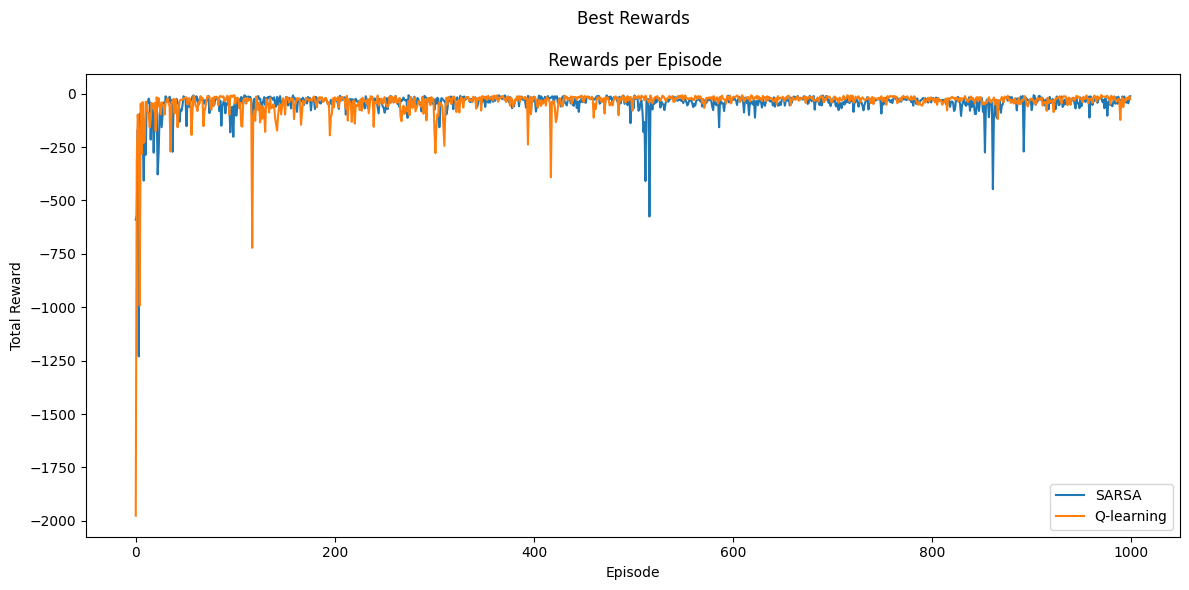

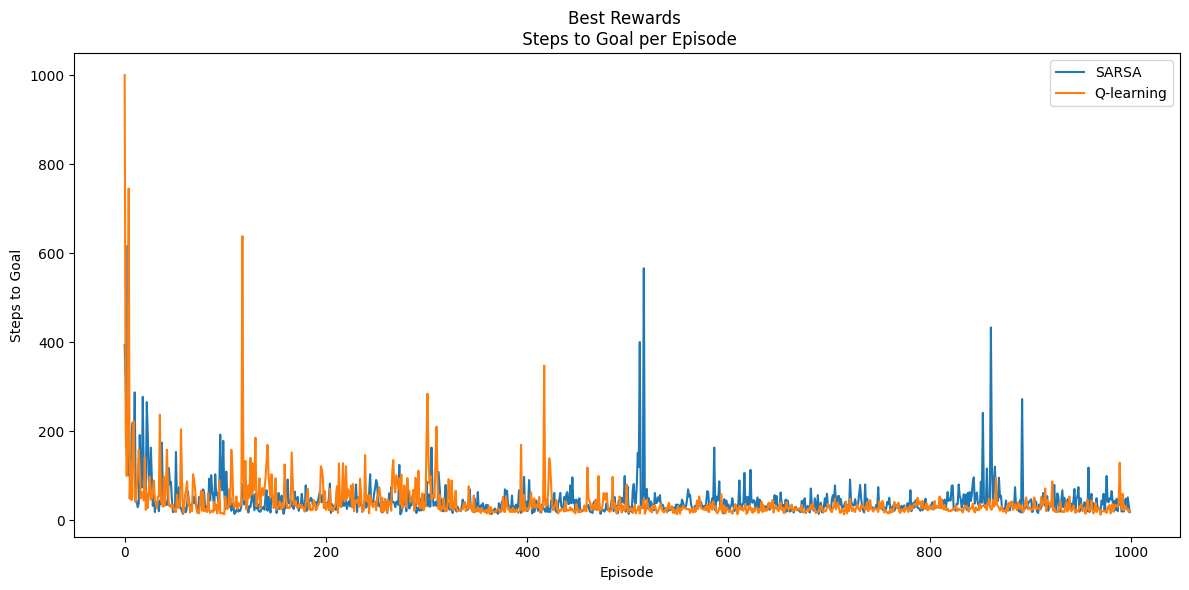

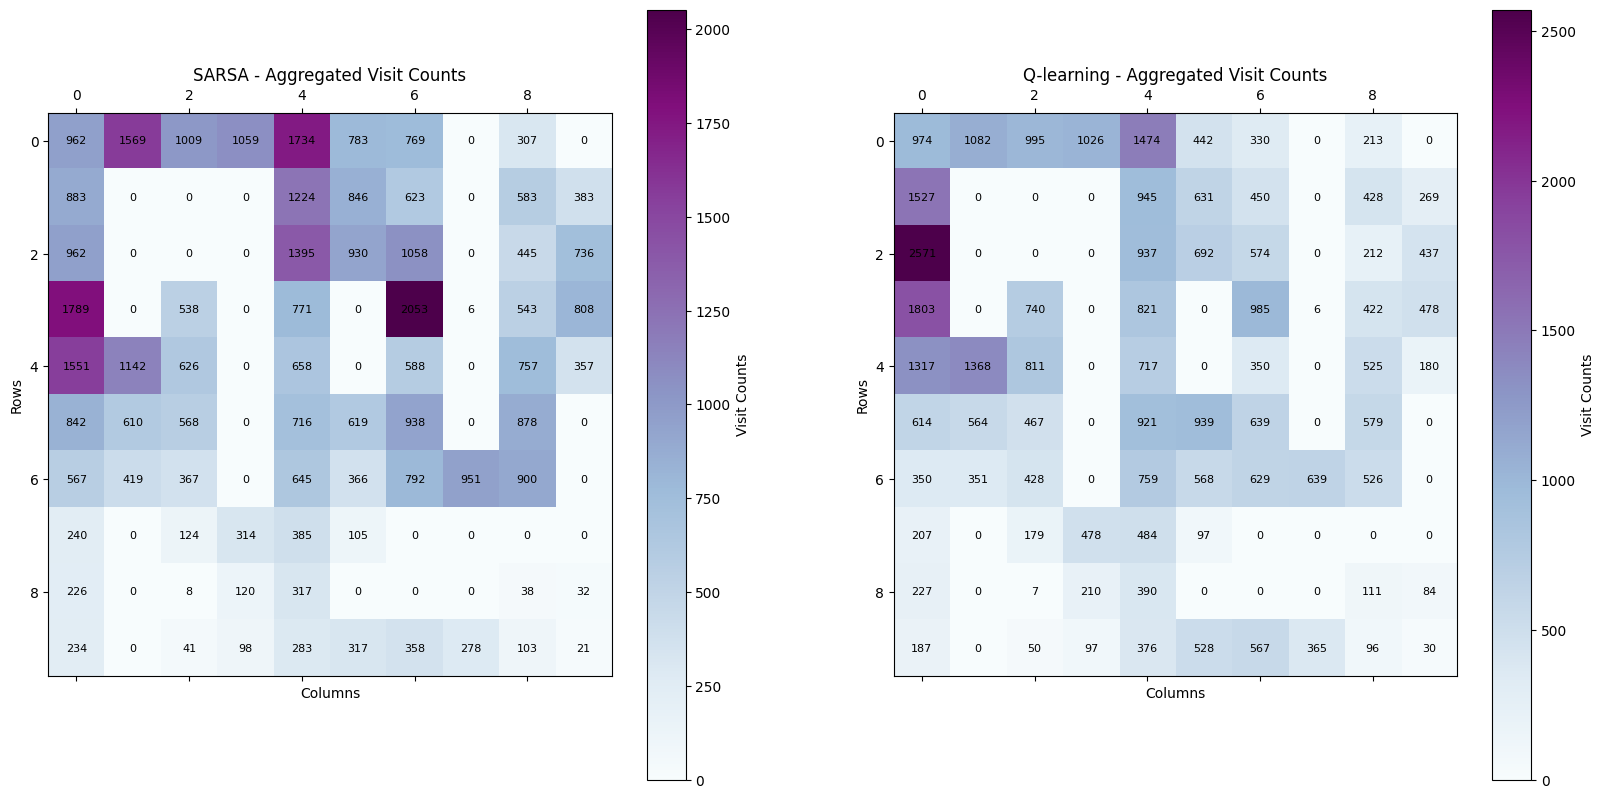

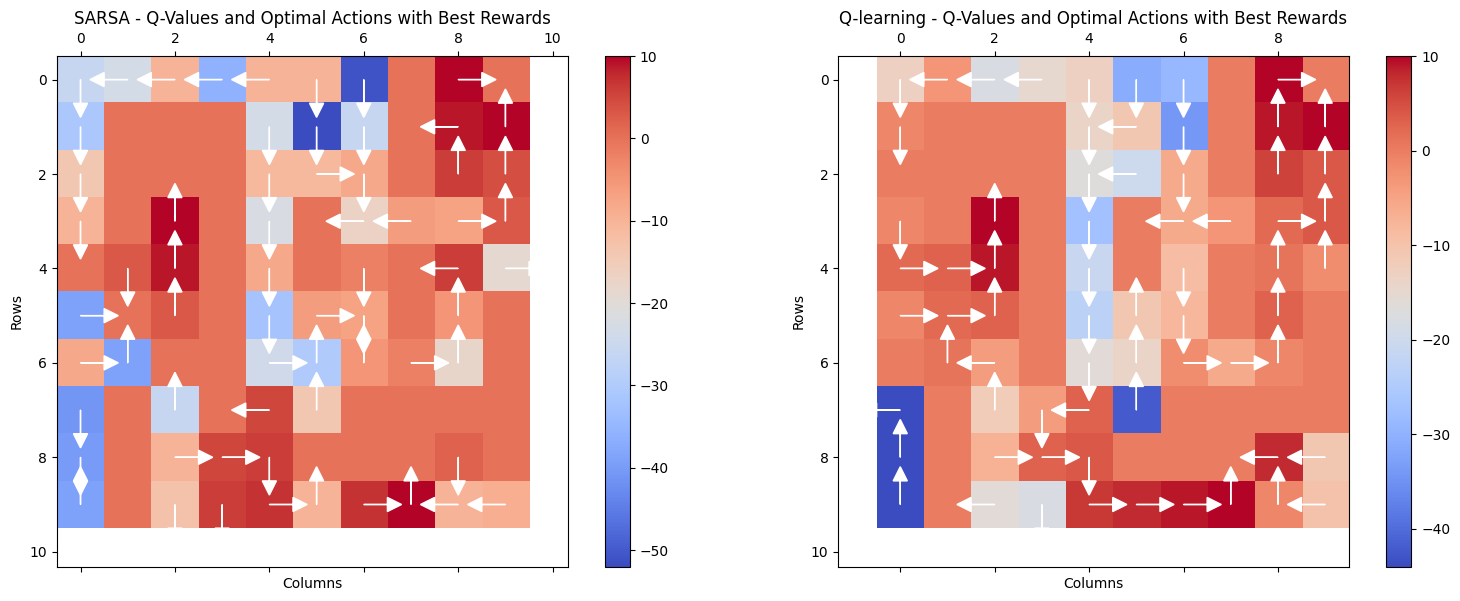

In [15]:
# Configurations
sarsa_param_grid = {
    'start_state': [[0, 4]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1], 
    'wind': [False], 
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['SARSA']
}

qlearning_param_grid = {
    'start_state': [[0, 4]],
    'alpha': [1],
    'gamma': [1.0],
    'epsilon': [0.001],
    'tau': [0],
    'p': [1.0], 
    'wind': [False],
    'exploration_strategy': ['epsilon-greedy'],
    'algorithm': ['Q-Learning']
}

param_grids = [sarsa_param_grid, qlearning_param_grid]
configurations = [config for grid in param_grids for config in ParameterGrid(grid)]

max_steps = 1000
n_agents = 50
episodes = 1000

# Best Hyperparameters and best rewards
best_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_rewards = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_agent = {'SARSA': {}, 'Q-Learning': {}}

# Best average Hyperparameters and best average rewards
best_avg_hyperparameters = {'SARSA': {}, 'Q-Learning': {}}
best_avg_reward = {'SARSA': -float('inf'), 'Q-Learning': -float('inf')}
best_avg_agent = {'SARSA': {}, 'Q-Learning': {}}

# Aggregated visit counts
aggregated_visit_counts = {'SARSA': np.zeros((env.num_rows, env.num_cols)).astype(int), 'Q-Learning': np.zeros((env.num_rows, env.num_cols)).astype(int)}
n = {'SARSA': 0, 'Q-Learning': 0}

def calculate_best_parameters(agent: RLAgent):
    algorithm  = agent.get_algorithm()
    aggregated_visit_counts[algorithm] += agent.get_visit_counts()
    hyperparameters = agent.get_hyperparameters()
    n[algorithm] += 1
    best_reward = max(agent.episode_rewards)
    avg_reward = np.mean(agent.episode_rewards)

    if avg_reward > best_avg_reward[algorithm]:
        best_avg_reward[algorithm] = avg_reward
        best_avg_hyperparameters[algorithm] = hyperparameters
        best_avg_agent[algorithm] = agent

    if best_reward > best_rewards[algorithm]:
        best_rewards[algorithm] = best_reward
        best_hyperparameters[algorithm] = hyperparameters
        best_agent[algorithm] = agent
    
def run_training(config):
    start_state = config['start_state']
    alpha = config['alpha']
    gamma = config['gamma']
    epsilon = config['epsilon']
    tau = config['tau']
    p = config['p']
    wind = config['wind']
    exploration_strategy = config['exploration_strategy']
    algorithm = config['algorithm']

    # size of the grid
    num_cols = 10
    num_rows = 10

    # coordinates of the cells representing obstruction
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

    # list of bad states
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

    # list of restart states
    restart_states = np.array([[3,7],[8,2]])

    # starting position
    start_state = np.array([start_state])

    # list of goal states i.e. terminal states
    goal_states = np.array([[0,9],[2,2],[8,7]])

    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind)

    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)

    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)
    env = gw.create_gridworld()

    agent = train_agent(env, start_state, wind, alpha, gamma, epsilon, tau, p, episodes=episodes, max_steps=max_steps, algorithm=algorithm, exploration_strategy=exploration_strategy)
    calculate_best_parameters(agent)
    return agent

expanded_configurations = [config for config in configurations for _ in range(n_agents)]

with ThreadPoolExecutor(max_workers=n_agents) as executor:
    results = list(tqdm(executor.map(run_training, configurations), total=len(configurations)))

agent_sarsa = best_agent['SARSA']
sarsa_hyperparameters = best_hyperparameters['SARSA']
sarsa_best_rewards = best_rewards['SARSA']

agent_qlearning = best_agent['Q-Learning']
qlearning_hyperparameters = best_hyperparameters['Q-Learning']
qlearning_best_rewards = best_rewards['Q-Learning']

agent_avg_sarsa = best_avg_agent['SARSA']
sarsa_avg_hyperparameters = best_avg_hyperparameters['SARSA']
sarsa_avg_rewards = best_avg_reward['SARSA']

agent_avg_qlearning = best_avg_agent['Q-Learning']
qlearning_avg_hyperparameters = best_avg_hyperparameters['Q-Learning']
qlearning_avg_rewards = best_avg_reward['Q-Learning']

sarsa_visit_count = aggregated_visit_counts['SARSA']
qlearning_visit_count = aggregated_visit_counts['Q-Learning']

sarsa_visit_average = np.divide(aggregated_visit_counts['SARSA'], n['SARSA']).astype(int)
qlearning_visit_average = np.divide(aggregated_visit_counts['Q-Learning'], n['Q-Learning']).astype(int)

q_values_sarsa, optimal_actions_sarsa = agent_sarsa.get_optimal_policy_and_q_values()
q_values_qlearning, optimal_actions_qlearning = agent_qlearning.get_optimal_policy_and_q_values()

print("Best Hyperparameters SARSA:", sarsa_hyperparameters)
print("Best Rewards SARSA:", sarsa_best_rewards)
print("Best Agent SARSA:", agent_sarsa)
print("Best Average Hyperparameters SARSA:", sarsa_avg_hyperparameters)
print("Best Average Rewards SARSA:", sarsa_avg_rewards)
print("Best Average Agent SARSA:", agent_avg_sarsa)
print("Sarsa Visit Count", sarsa_visit_count)
print("Sarsa Visit Count average", sarsa_visit_average)

print("Best Hyperparameters Q-Learning:", qlearning_hyperparameters)
print("Best Rewards Q-Learning:", qlearning_best_rewards)
print("Best Agent Q-Learning:", agent_qlearning)
print("Best Average Hyperparameters Q-Learning:", qlearning_avg_hyperparameters)
print("Best Average Rewards Q-Learning:", qlearning_avg_rewards)
print("Best Average Agent Q-Learning:", agent_avg_qlearning)
print("Q-Learning Visit Count", qlearning_visit_count)
print("Q-Learning Visit Count average", qlearning_visit_average)

print("n_sarsa:", n['SARSA'])
print("n_Q-Learning:", n['Q-Learning'])

print("Q-value SARSA:", q_values_sarsa)
print("Q-value Q-learning:", q_values_qlearning)

print("Optimal Actions SARSA:", optimal_actions_sarsa)
print("Optimal Actions Q-Learning:", optimal_actions_qlearning)

plot_rewards(agent_sarsa, agent_qlearning, f"Best Rewards\n\n")
# plot_rewards(agent_avg_sarsa, agent_avg_qlearning, f"Best Avg Rewards\n")

plot_steps(agent_sarsa, agent_qlearning, f"Best Rewards \n")
# plot_steps(agent_avg_sarsa, agent_avg_qlearning, f"Best Average Rewards\n")

plot_heatmap(sarsa_visit_count, qlearning_visit_count, "Aggregated Visit Counts")
# plot_heatmap(sarsa_visit_average,qlearning_visit_average, "Aggregated Average Visit Counts")

plot_visit_counts(agent_sarsa, agent_qlearning, "Best Rewards Visit Path")
# plot_visit_counts(agent_avg_sarsa, agent_avg_qlearning, "Best Average Rewards Visit Path")

plot_q_values_and_optimal_actions(agent_sarsa, agent_qlearning, f'Q-Values and Optimal Actions with Best Rewards')
# plot_q_values_and_optimal_actions(agent_avg_sarsa, agent_avg_qlearning, f'Q-Values and Optimal Actions with Best Average Rewards')

### SARSA

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

**SARSA with Wind:**
- **Best Hyperparameters:**
  - `start_state`: (3, 6)
  - `alpha`: 1
  - `gamma`: 1.0
  - `epsilon`: 0.001
  - `tau`: 0
  - `p`: 1
  - `wind`: True
  - `exploration_strategy`: epsilon-greedy
  - `algorithm`: SARSA
- **Best Rewards:** -1.0
- **Best Average Rewards:** -46.28
- **Visit Count:**
  - High variability in visits across different states and actions, indicating some actions/states are visited more frequently than others.
- **Q-Value Matrix:**
  - Contains some extreme values (e.g., -5021), which might indicate unstable learning or high penalties.

**SARSA without Wind:**
- **Best Hyperparameters:**
  - `start_state`: (3, 6)
  - `alpha`: 1
  - `gamma`: 1.0
  - `epsilon`: 0.001
  - `tau`: 0
  - `p`: 1
  - `wind`: False
  - `exploration_strategy`: epsilon-greedy
  - `algorithm`: SARSA
- **Best Rewards:** -1.0
- **Best Average Rewards:** -36.847
- **Visit Count:**
  - More consistent visit counts compared to the wind scenario, suggesting more stable exploration.
- **Q-Value Matrix:**
  - Q-values are generally less extreme, indicating more stable learning.

**Optimal Actions Comparison:**
- **SARSA:**
  - Actions vary between states with some actions consistently chosen in specific states.

2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

1. **Wind Effect:** The presence of wind seems to impact the learning stability and effectiveness, with Q-Learning performing better than SARSA in both cases.
2. **Algorithm Comparison:** Q-Learning tends to have more stable Q-values and better rewards compared to SARSA in the scenarios tested.
3. **State Visit Patterns:** Both algorithms show different patterns in state visits, which affect their learning and performance.

These results suggest that Q-Learning is more robust under varying conditions (wind vs. no wind) compared to SARSA, and that consistent exploration strategies (like those without wind) generally lead to better performance.

### Q Learning

1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

**Q-Learning with Wind:**
- **Best Hyperparameters:**
  - `start_state`: (3, 6)
  - `alpha`: 1
  - `gamma`: 1.0
  - `epsilon`: 0.001
  - `tau`: 0
  - `p`: 1.0
  - `wind`: True
  - `exploration_strategy`: epsilon-greedy
  - `algorithm`: Q-Learning
- **Best Rewards:** 0.0
- **Best Average Rewards:** -38.128
- **Visit Count:**
  - Visits show some patterns similar to SARSA with wind, but with different frequencies.
- **Q-Value Matrix:**
  - Values are less extreme than SARSA with wind, which might indicate more effective learning.

**Q-Learning without Wind:**
- **Best Hyperparameters:**
  - `start_state`: (3, 6)
  - `alpha`: 1
  - `gamma`: 1.0
  - `epsilon`: 0.001
  - `tau`: 0
  - `p`: 1.0
  - `wind`: False
  - `exploration_strategy`: epsilon-greedy
  - `algorithm`: Q-Learning
- **Best Rewards:** 0.0
- **Best Average Rewards:** -38.128
- **Visit Count:**
  - Shows more consistent exploration across states compared to Q-Learning with wind.
- **Q-Value Matrix:**
  - More stable Q-values compared to Q-Learning with wind.

**Optimal Actions Comparison:**
- **Q-Learning:**
  - Actions are generally more consistent across states compared to SARSA.

2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

1. **Wind Effect:** The presence of wind seems to impact the learning stability and effectiveness, with Q-Learning performing better than SARSA in both cases.
2. **Algorithm Comparison:** Q-Learning tends to have more stable Q-values and better rewards compared to SARSA in the scenarios tested.
3. **State Visit Patterns:** Both algorithms show different patterns in state visits, which affect their learning and performance.

These results suggest that Q-Learning is more robust under varying conditions (wind vs. no wind) compared to SARSA, and that consistent exploration strategies (like those without wind) generally lead to better performance.

## Analyzing with and without wind for state (0,4)

### With Wind:

**Results for SARSA:**

Reward: -6.0,
Average Reward: -70.55

**Results for Q-Learning:**

Reward: -6.0,
Average Reward: -68.891


### Without Wind:

**Results for SARSA:**

Reward: -7.0,
Average Reward: -43.618

**Results for Q-Learning:**

Best Reward: -6.0
Average Rewards: -40.393

1. **Q-values:**

Both algorithms show non-zero Q-values in various states, with notable differences in the magnitude and distribution of these values.

2. **Visit Counts:**

The visit counts indicate how often each state was visited during the training. Higher visit counts in certain states suggest those states were more critical or challenging for the agent.

3. **Optimal Actions:**

The optimal actions derived from both algorithms indicate the preferred direction to move in each state to maximize rewards. These actions differ slightly between SARSA and Q-Learning, reflecting the different policies learned by each algorithm.

4. **Performance:**

Both algorithms perform similarly in terms of best rewards, with Q-Learning having slightly better average rewards in both wind and no-wind conditions.

5. **Impact of Wind:**

The presence of wind increases the average reward (in absolute terms), suggesting that the environment becomes more challenging with wind.
#### Conclusion:
Both SARSA and Q-Learning performed well under the given conditions, with Q-Learning showing a slight edge in average performance. The choice of hyperparameters significantly affects the performance, with high values of alpha and gamma, and a very small epsilon yielding the best results in this case. The wind introduces additional complexity, reflected in the higher (in absolute terms) average rewards.